# Setup

Díky využití služeb  Google Colaboratory jsou veškeré příklady uvedené v této kapitole implementovány za využité jediného souboru Jupyter notebooku, který je konfigurován tak, aby jej po drobných úpravách (zejména lokalizaci příslušných dat uvnitř vlastního Google disku a autorizaci přístupu k tomuto Google disku uvnitř skriptu) mohl v prohlížeči spustit každý, kdo k němu prostřednictvím odkazu  získá přístup.

In [1]:
### these should go easy
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 150)

import numpy as np
import os
import string
import collections
import math
import random
import statistics as stat
import re
import unicodedata
import json

# Natural Language Processing Toolkit - we use it especially for building bigrams
import nltk
from nltk.collocations import *

### Beautiful Soup and Urllib
### for scrapping of web data and parsing xml files
from urllib.request import urlopen
# urllib and requests do basically the same, but my preferences are changing all the time, so let's import both
from urllib.parse import quote  
import requests
from bs4 import BeautifulSoup
### in some cases I prefer Element Tree
import xml.etree.cElementTree as ET


### for visualization
# in some cases I use matplotlib, which is much easier to configure, elsewhere I prefer Plotly, which is more "sexy"
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns

### to generate wordcloud data
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func

# There is a lot of changes in Plotly nowadays. Perhaps some modifications of the code will be needed at some point
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)

### for network analysis
import networkx as nx

### to export data to Google Spreadsheet
import gspread
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
from gspread_dataframe import get_as_dataframe, set_with_dataframe

### for data exchange with local harddrive
from google.colab import files

### for integration with sciencedata.dk datastorage (see https://pypi.org/project/sddk/)
!pip install sddk
import sddk

For an external data storage, this notebook relies on sciencedata.dk, accessed via sddk package. To write data to sciencedata.dk, you have to have a user account there (what is completely free and requires only a very simple configuration). However, for reading data from there within this notebook, you do not need such account.

In [4]:
### in the case you want just read data from sciencedata.dk, skip this cell
conf = sddk.configure_session_and_url()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [0]:
# establish connection with particular sheet by its url:
### useful for fast data export, feel free to skip
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1LtHGTRt3uygNLBq386wKV6G7-HitkWaUTh5V6UTGnVM/edit?usp=sharing")

# Getting Czech NT Data 

In [2]:
### open the New Testament in Czech Ecumenical Translation from GitHUB

url = "https://raw.githubusercontent.com/getbible/Bibles/master/Czech__Czech_CEP__cep__LTR.txt"
textfile = urlopen(url).read().decode("utf-8")
textfile[:100]

'01O||1||1||Na počátku stvořil Bůh nebe a zemi.\r\n01O||1||2||Země byla pustá a prázdná a nad propastno'

# Requirements

In [526]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import random

### Beautiful Soup and Urllib
### for scrapping of web data and parsing xml files
from urllib.request import urlopen
# urllib and requests do basically the same, but my preferences are changing all the time, so let's import both
from urllib.parse import quote  
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx

import unicodedata
import xml.etree.cElementTree as ET

In [203]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (4.25, 4.25)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

# Bible & NT in Czech Ecumenic Translation

In [17]:
bible = pd.read_csv("data/Bible_CEP.csv")
bible.head(5)
# alternatively, you can retrieve the data on your own from here:
#url = "https://raw.githubusercontent.com/getbible/Bibles/master/Czech__Czech_CEP__cep__LTR.txt"
#bible = pd.read_csv(url, sep=r"\|+", names=["book", "c", "v", "text"])

,book,c,v,text
0,01O,1,1,Na počátku stvořil Bůh nebe a zemi.
1,01O,1,2,Země byla pustá a prázdná a nad propastnou tůn...
2,01O,1,3,"I řekl Bůh: ""Buď světlo!"" A bylo světlo."
3,01O,1,4,"Viděl, že světlo je dobré, a oddělil světlo od..."
4,01O,1,5,Světlo nazval Bůh dnem a tmu nazval nocí. Byl ...


In [28]:
nt = bible[bible["book"].str.endswith("N")].copy()
nt.reset_index(drop=True, inplace=True)
nt.head(5)

,book,c,v,text
0,40N,1,1,"Listina rodu Ježíše Krista, syna Davidova, syn..."
1,40N,1,2,"Abraham měl syna Izáka, Izák Jákoba, Jákob Jud..."
2,40N,1,3,"Juda Farese a Záru z Támary, Fares měl syna Ch..."
3,40N,1,4,"Aram měl syna Amínadaba, Amínadab Naasona, Naa..."
4,40N,1,5,"Salmón měl syna Boaze z Rachaby, Boaz Obéda z ..."


In [29]:
nt_books_keys = nt["book"].unique()
nt_books_keys

array(['40N', '41N', '42N', '43N', '44N', '45N', '46N', '47N', '48N',
       '49N', '50N', '51N', '52N', '53N', '54N', '55N', '56N', '57N',
       '58N', '59N', '60N', '61N', '62N', '63N', '64N', '65N', '66N'],
      dtype=object)

In [30]:
# replace by standard book abbreviations
nt_books_abbrs = ['Mt', 'Mk', 'L', 'J', 'Sk', 'Ř', '1K', '2K', 'Ga', 'Ef', 'Fp', 'Ko', '1Te', '2Te', '1Tm', '2Tm', 'Tt', 'Fm', 'Žd', 'Jk', '1P', '2P', '1J', '2J', '3J', 'Ju', 'Zj']
nt_books_dict = dict(zip(nt_books_keys, nt_books_abbrs))
nt_books_dict["40N"]

'Mt'

In [32]:
nt["book_abbr"] = nt["book"].apply(lambda x: nt_books_dict[x])
nt = nt[["book_abbr", "c", "v", "text"]]
nt.head(5)

,book_abbr,c,v,text
0,Mt,1,1,"Listina rodu Ježíše Krista, syna Davidova, syn..."
1,Mt,1,2,"Abraham měl syna Izáka, Izák Jákoba, Jákob Jud..."
2,Mt,1,3,"Juda Farese a Záru z Támary, Fares měl syna Ch..."
3,Mt,1,4,"Aram měl syna Amínadaba, Amínadab Naasona, Naa..."
4,Mt,1,5,"Salmón měl syna Boaze z Rachaby, Boaz Obéda z ..."


In [33]:
nt[nt["book_abbr"]=="J"]["text"].values[:10]

array(['Na počátku bylo Slovo, to Slovo bylo u Boha, to Slovo byl Bůh.',
       'To bylo na počátku u Boha.',
       'Všechno povstalo skrze ně a bez něho nepovstalo nic, co jest.',
       'V něm byl život a život byl světlo lidí.',
       'To světlo ve tmě svítí a tma je nepohltila.',
       'Od Boha byl poslán člověk, jménem Jan.',
       'Ten přišel proto, aby vydal svědectví o tom světle, aby všichni uvěřili skrze něho.',
       'Jan sám nebyl tím světlem, ale přišel, aby o tom světle vydal svědectví.',
       'Bylo tu pravé světlo, které osvěcuje každého člověka; to přicházelo do světa.',
       'Na světě byl, svět skrze něj povstal, ale svět ho nepoznal.'],
      dtype=object)

# Functions for Data Cleaning and Preprocessing

In [104]:
def czech_sentences_maker(string):
  """splits text into sentences (not needed for the NT)"""
  text_splitted = re.split('([a-z|\"|ů|í|á|\d\d\d\d])(\.|\?|\!\s)', string)  
  sentences = []
  n = 0
  for element in text_splitted:
    n = n + 1
    if n == 1:
      sentence_main = element
    if n == 2:
      sentence_ending = element
    if n == 3:
      sentence_separator = element
      sentences.append(sentence_main + sentence_ending + sentence_separator)
      n = 0
  return sentences

def lemmata_filtered(string):
  try:
    url = 'http://lindat.mff.cuni.cz/services/morphodita/api/tag?data=' + quote(string)
    resp = urlopen(url)
    file = resp.read().decode("utf-8")
    result = dict(json.loads(file))["result"]
    soup = BeautifulSoup(result, 'html.parser')
    lemmata = []
    for token in soup.find_all("token"):
      if token["tag"].startswith(("V","N","A","C","D")):
        lemma = token["lemma"].partition("-")[0].partition("_")[0]
        if "`" in lemma:
          lemma = lemma.partition("`")[2]
        if len(lemma) > 1:
          lemmata.append(lemma)
  except:
    lemmata = [""]
  return lemmata

# Short one sentence long testing

In [105]:
test_string = "Hlas volajícího na poušti: Připravte cestu Páně, vyrovnejte mu stezky!"
test_data = []
url = 'http://lindat.mff.cuni.cz/services/morphodita/api/tag?data=' + quote(test_string)
resp = urlopen(url)
file = resp.read().decode("utf-8")
result = dict(json.loads(file))["result"]
soup = BeautifulSoup(result, 'html.parser')
for token in soup.find_all("token"):
  lemma = token["lemma"].partition("-")[0].partition("_")[0]
  test_data.append([token.get_text(), token["tag"], lemma])
test_data

[['Hlas', 'NNIS1-----A----', 'hlas'],
 ['volajícího', 'AGIS2-----A----', 'volající'],
 ['na', 'RR--6----------', 'na'],
 ['poušti', 'NNFS6-----A----', 'poušť'],
 [':', 'Z:-------------', ':'],
 ['Připravte', 'Vi-P---2--A----', 'připravit'],
 ['cestu', 'NNFS4-----A----', 'cesta'],
 ['Páně', 'NNMS2-----A---2', 'Pán'],
 [',', 'Z:-------------', ','],
 ['vyrovnejte', 'Vi-P---2--A----', 'vyrovnat'],
 ['mu', 'PHZS3--3-------', 'on'],
 ['stezky', 'NNFP4-----A----', 'stezka'],
 ['!', 'Z:-------------', '!']]

In [106]:
nt.values.tolist()[:3]

[['Mt', 1, 1, 'Listina rodu Ježíše Krista, syna Davidova, syna Abrahamova.'],
 ['Mt',
  1,
  2,
  'Abraham měl syna Izáka, Izák Jákoba, Jákob Judu a jeho bratry,'],
 ['Mt',
  1,
  3,
  'Juda Farese a Záru z Támary, Fares měl syna Chesróma, Chesróm Arama.']]

In [72]:
pd.DataFrame(test_data).to_csv("data/test_sentence.csv", index=False)

In [73]:
%%time

### MAIN FUNCTION APPLIATION
### the text is lemmatized verse by verse and a dictionary of NT books is formed
### the dictionary element for each book is a dictionary containing:
### (1) "book_length_orig" = number of words in the source text
### (2) "book_length_filtered" = number of lemmatized words in the filtered text
### (3) "book_lemmata" = filtered lemmata as a list of words
### (4) "book_by_verse" = a list of list with cells for (a) book chapter, (b) verse number, (c) original text of the verse, (d) filtered lemmata for the verse

nt_data = {}
for book_abbr in nt["book_abbr"].unique().tolist():
  actual_book = nt[nt["book_abbr"]==book_abbr]
  book_lemmata = [] 
  book_length_orig = 0
  book_by_verse = []
  for verse_row in actual_book.values.tolist():
    verse_lemmata = lemmata_filtered(verse_row[3])
    book_lemmata.extend(verse_lemmata)
    book_length_orig = book_length_orig + len(str(verse_row[3]).split())
    book_by_verse.append([verse_row[1], verse_row[2], verse_row[3], verse_lemmata])
  book_length_filtered = len(book_lemmata)
  nt_data.update({book_abbr : {"book_length_orig" : book_length_orig, "book_length_filtered" : book_length_filtered, "book_lemmata" : book_lemmata, "book_by_verse" : book_by_verse}})

In [74]:
print(nt_data["Mk"]["book_lemmata"][:100])

['počátek', 'evangelium', 'Ježíš', 'Kristus', 'syn', 'boží', 'být', 'psát', 'prorok', 'Izaiáš', 'posílat', 'posel', 'tvář', 'být', 'připravit', 'cesta', 'hlas', 'volající', 'poušť', 'připravit', 'cesta', 'Pán', 'vyrovnat', 'stezka', 'stát', 'Jan', 'křtitel', 'vystoupit', 'poušť', 'kázat', 'činit', 'pokání', 'dát', 'pokřtít', 'odpuštění', 'hřích', 'celý', 'judský', 'krajina', 'Jeruzalém', 'vycházet', 'vyznávat', 'hřích', 'dávat', 'křtít', 'řeka', 'Jordán', 'Jan', 'být', 'odít', 'velbloudí', 'srst', 'mít', 'kožený', 'pás', 'bok', 'jíst', 'kobylka', 'med', 'divoký', 'včela', 'kázat', 'přicházet', 'silný', 'být', 'být', 'hodný', 'sklonit', 'rozvázat', 'řemínek', 'obuv', 'být', 'křtít', 'voda', 'být', 'křtít', 'duch', 'svatý', 'den', 'přijít', 'Ježíš', 'Nazaret', 'Galilea', 'být', 'Jordán', 'Jan', 'pokřtít', '', 'nebe', 'ozvat', 'hlas', 'být', 'milovaný', 'syn', 'být', 'vyvolit', 'hned', 'duch', 'vyvést', 'poušť']


In [75]:
with open("data/nt_data.json", "w") as f:
    json.dump(nt_data, f)
# to read it back, use:
# nt_data = json.load(open("data/nt_data.json"))
    

# To start with preprocessed data

In [51]:
nt_data = json.load(open("data/nt_data.json"))

In [58]:
print(nt_data["Mk"]["book_by_verse"][:5])

[[1, 1, 'Počátek evangelia Ježíše Krista, Syna Božího.', ['počátek', 'evangelium', 'Ježíš', 'Kristus', 'syn', 'boží']], [1, 2, "Je psáno u proroka Izaiáše: 'Hle, já posílám posla před tvou tváří, by ti připravil cestu.", ['být', 'psát', 'prorok', 'Izaiáš', 'posílat', 'posel', 'tvář', 'být', 'připravit', 'cesta']], [1, 3, "Hlas volajícího na poušti: Připravte cestu Páně, vyrovnejte mu stezky!'", ['hlas', 'volající', 'poušť', 'připravit', 'cesta', 'Pán', 'vyrovnat', 'stezka']], [1, 4, 'To se stalo, když Jan Křtitel vystoupil na poušti a kázal: "Čiňte pokání a dejte se pokřtít na odpuštění hříchů."', ['stát', 'Jan', 'křtitel', 'vystoupit', 'poušť', 'kázat', 'činit', 'pokání', 'dát', 'pokřtít', 'odpuštění', 'hřích']], [1, 5, 'Celá judská krajina i všichni z Jeruzaléma vycházeli k němu, vyznávali své hříchy a dávali se od něho křtít v řece Jordánu.', ['celý', 'judský', 'krajina', 'Jeruzalém', 'vycházet', 'vyznávat', 'hřích', 'dávat', 'křtít', 'řeka', 'Jordán']]]


In [94]:
def remove_spacewords(lemmata_list):
    return [l for l in lemmata_list if len(l) > 0]

for key in nt_data.keys():
    new_lemmata = remove_spacewords(nt_data[key]["book_lemmata"])
    nt_data[key]["book_lemmata"] = new_lemmata

In [96]:
### for some overview it might be easier to use a dataframe format
nt_data_df = pd.DataFrame.from_dict(nt_data, orient="index")
nt_data_df.head(4)

,book_length_orig,book_length_filtered,book_lemmata,book_by_verse
Mt,16816,9613,"[listina, rod, Ježíš, Kristus, syn, Davidov, s...","[[1, 1, Listina rodu Ježíše Krista, syna David..."
Mk,10537,5373,"[počátek, evangelium, Ježíš, Kristus, syn, bož...","[[1, 1, Počátek evangelia Ježíše Krista, Syna ..."
L,18425,9608,"[již, mnohý, pokusit, sepsat, vypravování, udá...","[[1, 1, I když se již mnozí pokusili sepsat vy..."
J,14163,7486,"[počátek, být, slovo, slovo, být, bůh, slovo, ...","[[1, 1, Na počátku bylo Slovo, to Slovo bylo u..."


In [97]:
nt_data_df["book_length_orig"].sum()

134188

In [98]:
nt_data_df["book_length_filtered"].sum()

71691

In [99]:
### TF separately
TF = nt_data["J"]["book_lemmata"].count("učedník") / nt_data["J"]["book_length_orig"]
TF

0.005295488244016098

In [102]:
ev_wordfreqs = pd.DataFrame()
for ev in ["Mt", "Mk", "L", "J"]:
    wordcounts_raw = nltk.FreqDist(nt_data[ev]["book_lemmata"]).most_common(11)[1:]
    ev_wordfreqs[ev] = [tup[0] + " ({0})".format(str(np.round(tup[1] / nt_data[ev]["book_length_orig"], 5))) for tup in wordcounts_raw]
ev_wordfreqs

,Mt,Mk,L,J
0,říci (0.01362),říci (0.01405),říci (0.01433),říci (0.01793)
1,Ježíš (0.00934),Ježíš (0.00864),mít (0.00738),Ježíš (0.01553)
2,mít (0.0069),mít (0.00721),Ježíš (0.00619),otec (0.00826)
3,člověk (0.0063),přijít (0.00598),člověk (0.00608),mít (0.00791)
4,jít (0.00613),jít (0.00598),přijít (0.00526),přijít (0.006)
5,syn (0.00589),člověk (0.00531),dát (0.00412),odpovědět (0.00572)
6,přijít (0.00589),učedník (0.00418),syn (0.00407),učedník (0.0053)
7,dát (0.00446),jak (0.00342),jít (0.00396),svět (0.00501)
8,odpovědět (0.00422),říkat (0.00332),den (0.00391),dát (0.00466)
9,učedník (0.00422),dát (0.00304),jak (0.00336),člověk (0.00459)


In [107]:
ev_wordfreqs.to_csv("CEP_ev_wordfreqs.csv", index=False)

# Czech networks

In [345]:
# for convenience, you can simply start here
nt_data_dict = json.load(open("data/nt_data.json"))
# nt_data = sddk.read_file("https://sciencedata.dk/shared/d58d13b674881c9b7ca8ba3dff25c51d?download", "dict")
  
evangelia = ["Mt", "Mk", "L", "J"]

In [346]:
### after recent changes, it is more meaningful to turn to dataframe here

nt_data = pd.DataFrame(nt_data_dict).T.reset_index()
nt_data.head(4)

,index,book_length_orig,book_length_filtered,book_lemmata,book_by_verse
0,Mt,16816,9613,"[listina, rod, Ježíš, Kristus, syn, Davidov, s...","[[1, 1, Listina rodu Ježíše Krista, syna David..."
1,Mk,10537,5373,"[počátek, evangelium, Ježíš, Kristus, syn, bož...","[[1, 1, Počátek evangelia Ježíše Krista, Syna ..."
2,L,18425,9608,"[již, mnohý, pokusit, sepsat, vypravování, udá...","[[1, 1, I když se již mnozí pokusili sepsat vy..."
3,J,14163,7486,"[počátek, být, slovo, slovo, být, bůh, slovo, ...","[[1, 1, Na počátku bylo Slovo, to Slovo bylo u..."


In [350]:
nt_data["verses_lemmata"] = nt_data["book_by_verse"].apply(lambda book_by_verse: [verse[3] for verse in book_by_verse])

In [351]:
nt_data.rename(columns={"index": "author"}, inplace=True)
nt_data.head(4)

,author,book_length_orig,book_length_filtered,book_lemmata,book_by_verse,verses_lemmata
0,Mt,16816,9613,"[listina, rod, Ježíš, Kristus, syn, Davidov, s...","[[1, 1, Listina rodu Ježíše Krista, syna David...","[[listina, rod, Ježíš, Kristus, syn, Davidov, ..."
1,Mk,10537,5373,"[počátek, evangelium, Ježíš, Kristus, syn, bož...","[[1, 1, Počátek evangelia Ježíše Krista, Syna ...","[[počátek, evangelium, Ježíš, Kristus, syn, bo..."
2,L,18425,9608,"[již, mnohý, pokusit, sepsat, vypravování, udá...","[[1, 1, I když se již mnozí pokusili sepsat vy...","[[již, mnohý, pokusit, sepsat, vypravování, ud..."
3,J,14163,7486,"[počátek, být, slovo, slovo, být, bůh, slovo, ...","[[1, 1, Na počátku bylo Slovo, to Slovo bylo u...","[[počátek, být, slovo, slovo, být, bůh, slovo,..."


In [486]:
def network_from_list_of_lists(list_of_lists):
    stringlist = [" ".join(el) for el in list_of_lists]
    vectorizer = CountVectorizer(lowercase=False)
    X = vectorizer.fit_transform(stringlist)
    Xc = X.T * X
    wordcounts = X.toarray().sum(axis=0)
    nodes_dict = dict([(pair[1], {"wordcount" : wordcounts[pair[1]]}) for pair in vectorizer.vocabulary_.items()])
    labels_mapping = dict([(pair[1], pair[0]) for pair in vectorizer.vocabulary_.items()])
    G = nx.from_numpy_matrix(Xc.toarray())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.set_node_attributes(G, nodes_dict)
    G = nx.relabel_nodes(G, labels_mapping)
    isolates = list(nx.isolates(G))
    G.remove_nodes_from(isolates)
    total_weight = sum([int(n) for n in nx.get_edge_attributes(G, "weight").values()])
    for (u, v) in G.edges:
        G[u][v]["norm_weight"] = round((G[u][v]["weight"] / total_weight), 5)
        G[u][v]["distance"] = round(1 / (G[u][v]["weight"]), 5)
        G[u][v]["norm_distance"] = round(1 / (G[u][v]["norm_weight"] ), 5)
    return G

def network_from_df_lemmata_list_col(df, data_col, select_col, select_col_val, lexicon_size=500, threshold=2, stopwords=[]):
    '''From one or more documents within a dataframe with rows corresponding to individual documents,
    to be subsellected on the basis of author's name column, for instance.
    The values of the input cell is a list of lemmatized words'''
    works = df[df[select_col]==select_col_val][data_col].tolist()
    works_merged = [item for sublist in works for item in sublist]
    lexicon = [word_tuple[0] for word_tuple in nltk.FreqDist(works_merged).most_common(lexicon_size)]
    bigrams_list = []
    for work in works:
        lemmata_list = [lemma for lemma in work if lemma not in stopwords]
        bigrams_list.extend([bigram for bigram in nltk.bigrams(lemmata_list)])
    G = network_from_list_of_lists(bigrams_list)
    # filter for a subset of nodes and edges
    G.remove_nodes_from([n for n in G.nodes if n not in lexicon])
    G.remove_edges_from([(s,t) for (s,t) in G.edges if G[s][t]["weight"] < threshold])
    return G

def network_from_df_sentences_col(df, data_col, select_col, select_col_val, lexicon_size=500, threshold=2, stopwords=[]):
    '''From one or more documents within a dataframe with rows corresponding to individual documents,
    to be subsellected on the basis of author's name column, for instance.
    The values of the input cell is a list of lemmatized sentences'''
    works = df[df[select_col]==select_col_val][data_col].tolist()
    sentences_merged = [item for sublist in works for item in sublist]
    sentences_merged = [[w for w in sentence if w not in stopwords] for sentence in sentences_merged]
    lemmata_list = [item for sublist in sentences_merged for item in sublist]
    lexicon = [word_tuple[0] for word_tuple in nltk.FreqDist(lemmata_list).most_common(lexicon_size)]
    G = network_from_list_of_lists(sentences_merged)
    # filter for a subset of nodes and edges
    G.remove_nodes_from([n for n in G.nodes if n not in lexicon])
    G.remove_edges_from([(s,t) for (s,t) in G.edges if G[s][t]["weight"] < threshold])
    return G
                        
def network_from_lemmata_list(lemmata_list, lexicon_size=500, threshold=2, stopwords=[]):
    '''From a list of words'''
    lemmata_list = [lemma for lemma in lemmata_list if lemma not in stopwords]
    lexicon = [word_tuple[0] for word_tuple in nltk.FreqDist(lemmata_list).most_common(lexicon_size)]
    bigrams_list = [bigram for bigram in nltk.bigrams(lemmata_list)]
    G = network_from_list_of_lists(bigrams_list)
    # filter for a subset of nodes and edges
    G.remove_nodes_from([n for n in G.nodes if n not in lexicon])
    G.remove_edges_from([(s,t) for (s,t) in G.edges if G[s][t]["weight"] < threshold])
    return G

def ego_network_data(df, data_col, select_col, select_col_val, term, num_of_neighbours):
    '''create network and ego network on its basis
    specify source term and number of neighbors
    includes only shortest paths from the source'''
    if isinstance(df[data_col].tolist()[0][0], str): # if flat list, i.e. list of lemmata
        # form bigrams:
        network = network_from_df_lemmata_list_col(df, data_col, select_col, select_col_val, 500, 1)
    else:
        network = network_from_df_sentences_col(df, data_col, select_col, select_col_val, 500, 1)
    length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
    shortest_nodes = list(length.keys())[0:num_of_neighbours+1]
    path_values_sorted = [dict_pair[1] for dict_pair in sorted(path.items(), key=lambda pair: list(length.keys()).index(pair[0]))]
    path_edges = []
    for path_to_term in path_values_sorted[1:num_of_neighbours+1]:
        path_edges.extend([tuple(sorted(bigram)) for bigram in nltk.bigrams(path_to_term)])
    shortest_edges = list(set(path_edges))
    ego_network = network.copy(as_view=False)
    ego_network.remove_nodes_from([n for n in ego_network.nodes if n not in shortest_nodes])
    ego_network.remove_edges_from([e for e in ego_network.edges if e not in shortest_edges])
    #ego_network.remove_edges_from([e for e in ego_network.edges if (e[1], e[0]) not in shortest_edges])
    ego_network_data_prec = sorted(list(ego_network.edges.data("weight")), key=lambda tup: int(tup[2]), reverse=True)
    ego_network_data_complete = []
    for tup in ego_network_data_prec:
      if tup[1] == term:
        ego_network_data_complete.append([tup[1], tup[0], int(tup[2]), round(1 / int(tup[2]), 5)])
      else:
        ego_network_data_complete.append([tup[0], tup[1], int(tup[2]), round(1 / int(tup[2]), 5)])
    return ego_network_data_complete

def plot_network_simple(G, N_nodes=len(G.nodes), node_size_attr="wordcount", edge_width_attr="weight", margins=0.3, font_size=5, ax=None):
    """a more simple variant of the same"""
    nodes_sorted_tups =  node_sizes = sorted([(node[0], node[1][node_size_attr]) for node in G.nodes(data=True)], key=lambda x: x[1], reverse=True)
    nodes_lables_sorted = [tup[0] for tup in nodes_sorted_tups]
    ###
    H = G.subgraph(nodes_lables_sorted[:N_nodes])
    #node_colors = [color_dict[node] for node in H.nodes()]
    edge_weights = nx.get_edge_attributes(H, edge_width_attr).values()
    edge_widths = [8 * (w / max(edge_weights)) for w in edge_weights]
    node_weights = nx.get_node_attributes(H, node_size_attr).values()
    node_sizes = [100 * (w / max(node_weights)) for w in node_weights]
    pos = nx.kamada_kawai_layout(H, weight="norm_distance")
    if ax == None:
        fig, ax = plt.subplots()
    x_min, x_max, y_min, y_max = np.min([p[0] for p in pos.values()]), np.max([p[0] for p in pos.values()]), np.min([p[1] for p in pos.values()]), np.max([p[1] for p in pos.values()]) 
    ax.set_xlim(x_min - margins, x_max + margins)
    ax.set_axis_off()
    layer_edges = nx.draw_networkx_edges(H,
                          pos=pos,
                          alpha=1,
                          width= edge_widths,
                          style="solid",
                          edge_color="darkgray",
                          ax=ax)
    layer_nodes = nx.draw_networkx_nodes(H,
                           pos=pos,
                           node_size=node_sizes,
                           node_color="lightgrey",
                           linewidths=1,
                           ax=ax)
    layer_labels = nx.draw_networkx_labels(H,
                           pos=pos, 
                           font_size=font_size,
                           ax=ax)
    layers = [layer_edges, layer_nodes, layer_labels]
    return layers


def ego_network_drawing_reduced(network, term, num_of_neighbours, ax=None):
    '''derrive ego network from a preexisting network
    specify source term and number of neighbors
    includes only shortest paths from the source'''
    length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
    shortest_nodes = list(length.keys())[0:num_of_neighbours+1]
    path_values_sorted = [dict_pair[1] for dict_pair in sorted(path.items(), key=lambda pair: list(length.keys()).index(pair[0]))]
    path_edges = []
    for path_to_term in path_values_sorted[1:num_of_neighbours+1]:
        path_edges.extend([tuple(sorted(bigram)) for bigram in nltk.bigrams(path_to_term)])
    shortest_edges = list(set(path_edges))
    ego_network = network.copy(as_view=False)
    ego_network.remove_nodes_from([n for n in ego_network.nodes if n not in shortest_nodes])
    ego_network.remove_edges_from([e for e in ego_network.edges if e not in shortest_edges])
    #ego_network.remove_edges_from([e for e in ego_network.edges if (e[1], e[0]) not in shortest_edges])
    layer = plot_network_simple(ego_network, ax=ax)
    return layer 

def ego_network_standard(df, data_col, select_col, select_col_val, term, threshold=2, stopwords=[], ax=None):
    if isinstance(df[data_col].tolist()[0][0], str): # if flat list, i.e. list of lemmata
        # form bigrams:
        network = network_from_df_lemmata_list_col(df, data_col, select_col, select_col_val, threshold=threshold, stopwords=stopwords)
    else:
        network = network_from_df_sentences_col(df, data_col, select_col, select_col_val, threshold=threshold, stopwords=stopwords)
    ego_network_drawing_reduced(network, term, 30, ax=ax)

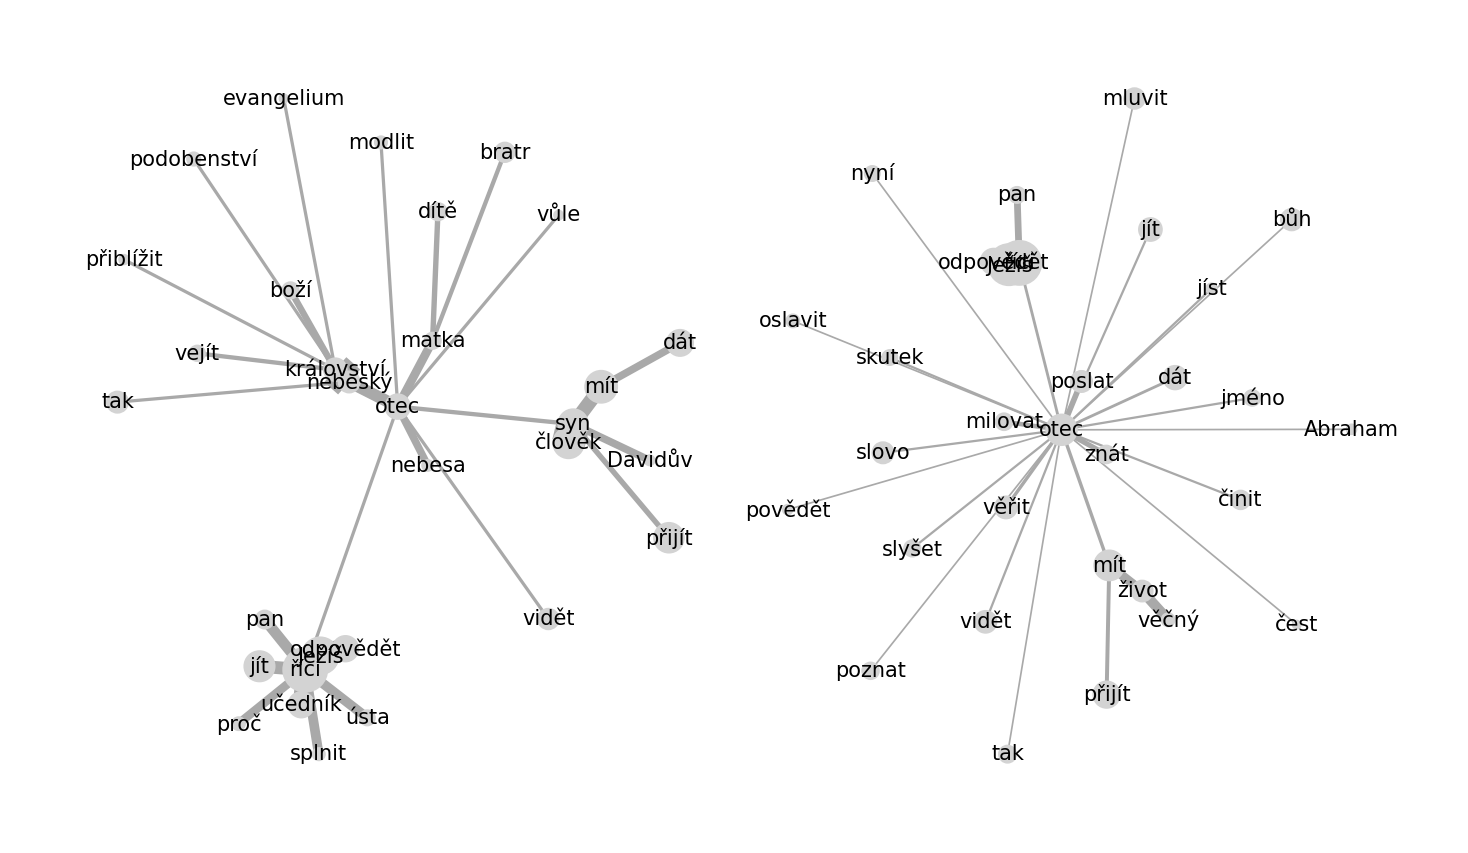

In [480]:
# based on bigrams:

stopwords = ["εἰμί", "být"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.25, 2.2))
ego_network_standard(nt_data, "book_lemmata", "author", "Mt", "otec", stopwords=["být"], threshold=2, ax=ax1)
ego_network_standard(nt_data, "book_lemmata", "author", "J", "otec", stopwords=["být"], threshold=2, ax=ax2)
fig.tight_layout(pad=-2)

In [439]:
fig.savefig("figures/network_Mt+J_otec.png", bbox_inches='tight', pad_inches=0)
fig.savefig("figures/network_Mt+J_otec.eps", bbox_inches='tight', pad_inches=0)

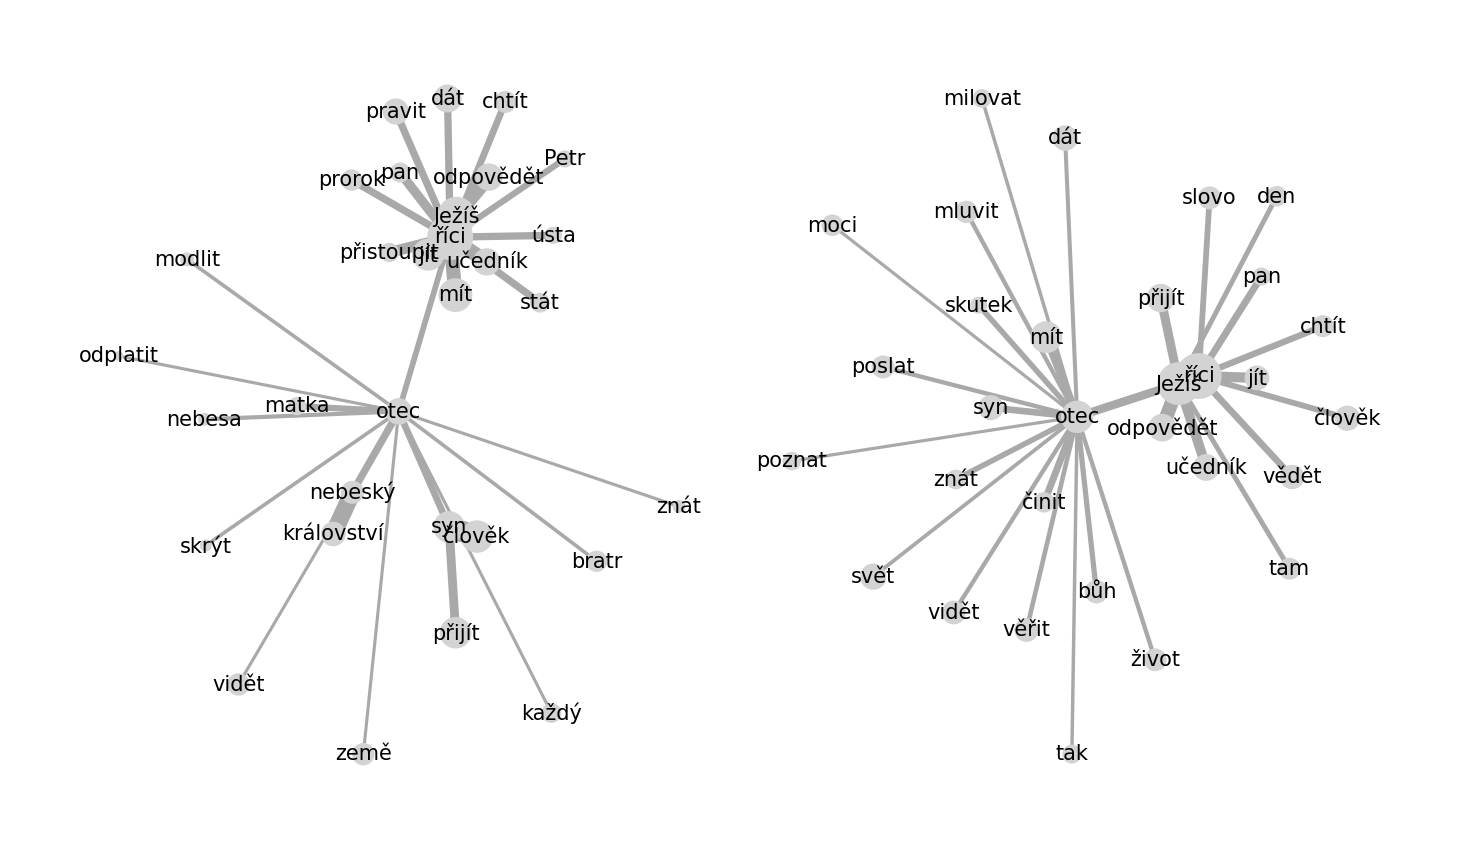

In [441]:
# based on sentences:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.25, 2.2))
ego_network_standard(nt_data, "verses_lemmata", "author", "Mt", "otec", stopwords=["být"], ax=ax1)
ego_network_standard(nt_data, "verses_lemmata", "author", "J", "otec", stopwords=["být"], ax=ax2)
fig.tight_layout(pad=-2)

In [447]:
network_data_overview = []
for book_abbr in evangelia:
    actual_network_data = list(network_from_df_lemmata_list_col(nt_data, "book_lemmata", "author", book_abbr, stopwords=["být"]).edges.data("weight"))
    actual_network_data = sorted(actual_network_data, key=lambda x: int(x[2]), reverse=True)
    network_data_overview.append(actual_network_data[:10])

In [448]:
evanglia_networks_overview = pd.DataFrame(network_data_overview).T
evanglia_networks_overview.columns = ["Mt", "Mk", "L", "J"]
evanglia_networks_overview

,Mt,Mk,L,J
0,"(království, nebeský, 31)","(Ježíš, říci, 23)","(boží, království, 30)","(Ježíš, říci, 59)"
1,"(syn, člověk, 31)","(boží, království, 12)","(syn, člověk, 26)","(Ježíš, odpovědět, 40)"
2,"(Ježíš, říci, 27)","(duch, zlý, 11)","(Ježíš, říci, 23)","(věčný, život, 18)"
3,"(Ježíš, odpovědět, 20)","(syn, člověk, 11)","(duch, svatý, 13)","(mít, život, 16)"
4,"(učedník, říci, 16)","(duch, čistý, 10)","(den, kdy, 12)","(Petr, Šimon, 15)"
5,"(mít, syn, 13)","(jít, říci, 10)","(pan, říci, 12)","(syn, člověk, 13)"
6,"(jít, říci, 12)","(učedník, říci, 10)","(pán, říci, 12)","(pan, říci, 12)"
7,"(farizeus, zákoník, 11)","(Magdala, Marie, 7)","(učedník, říci, 12)","(jít, říci, 11)"
8,"(nebeský, otec, 11)","(matka, otec, 7)","(jak, říci, 11)","(boží, syn, 10)"
9,"(prorok, ústa, 11)","(chtít, říci, 6)","(jít, říci, 10)","(otec, poslat, 10)"


In [449]:
evanglia_networks_overview.to_csv("evanglia_networks_overview.csv", index=False)

In [450]:
#network_formation_df(dataset, column, book_abbr, lexicon_size, threshold)"

### generate networks and show words with max betweenness
def generate_network_and_betweenness(name):
    network = network_from_df_lemmata_list_col(nt_data, "book_lemmata", "author", name, 500, 2)
    betweenness_dict = nx.betweenness_centrality(network, weight="distance", normalized=True)
    betweenness_dict = sorted(betweenness_dict.items(), key = lambda x : x[1], reverse=True)
    return [name, betweenness_dict]
for book in evangelia:
  print(generate_network_and_betweenness(book))

['Mt', [('být', 0.632906374998994), ('říci', 0.20452149278476628), ('Ježíš', 0.059772825436683275), ('mít', 0.04168712257178346), ('člověk', 0.028064160449412883), ('jít', 0.02310779524242595), ('učedník', 0.022873055347643077), ('pravit', 0.02116079548655544), ('syn', 0.019645717137085416), ('otec', 0.016394234251635803), ('přijít', 0.016366065464261857), ('přísahat', 0.016305703777031975), ('dát', 0.016116570490378346), ('dobrý', 0.013150799591150172), ('den', 0.01307031734151033), ('ruka', 0.01307031734151033), ('tělo', 0.012844967042518772), ('země', 0.012772533017842915), ('království', 0.012671259520379447), ('vstát', 0.012362073544679721), ('odpovědět', 0.010372820607748294), ('celý', 0.009927485493074503), ('vzít', 0.00986712380584462), ('ústa', 0.00986712380584462), ('chtít', 0.009842979130952669), ('tak', 0.009834930905988684), ('bratr', 0.009786641556204779), ('život', 0.008130719269865031), ('služebník', 0.006615640920395007), ('místo', 0.006599544470467038), ('Galilea', 0.

['Mk', [('být', 0.2587600569952513), ('říci', 0.11833921871254297), ('mít', 0.03420119108223639), ('Ježíš', 0.03391028904349793), ('přijít', 0.02325061479991057), ('říkat', 0.01961972639047134), ('duch', 0.013130994804166364), ('učedník', 0.013044801607503119), ('člověk', 0.011135083593933075), ('chléb', 0.011054277472061284), ('zákoník', 0.010828020330820263), ('jít', 0.010569440740830525), ('slyšet', 0.010359344823963864), ('Jan', 0.008702819325592106), ('jak', 0.008258385655297245), ('otec', 0.008258385655297245), ('vzít', 0.008223369669152802), ('zástup', 0.00682407699207292), ('ruka', 0.006638222911767795), ('celý', 0.006569537708176771), ('matka', 0.006569537708176771), ('dát', 0.006553376483802413), ('velekněz', 0.006545295871615234), ('místo', 0.006496812198492158), ('ptát', 0.006375603015684468), ('druhý', 0.0044685785395101535), ('země', 0.004412014254199898), ('boží', 0.00438777241763836), ('bůh', 0.00438777241763836), ('dítě', 0.00438777241763836), ('hlas', 0.00438777241763

['L', [('být', 0.499990572619115), ('říci', 0.16896560083391915), ('mít', 0.045747039129017744), ('den', 0.028888188569165998), ('Ježíš', 0.02808551442523952), ('jít', 0.01989446720483544), ('člověk', 0.017222478108274812), ('město', 0.014722875405040685), ('bůh', 0.014585504997858637), ('přijít', 0.011712847365316395), ('jméno', 0.011644162161725372), ('jíst', 0.011474469305794606), ('chléb', 0.008856350957148514), ('bratr', 0.008824028508399796), ('poslat', 0.008824028508399796), ('veliký', 0.008824028508399796), ('říkat', 0.008824028508399796), ('dobrý', 0.008799786671838257), ('odpovědět', 0.008799786671838257), ('zákoník', 0.008799786671838257), ('vědět', 0.008759383610902362), ('pozor', 0.008516965245286983), ('celý', 0.007399147226060513), ('pak', 0.0059150081210152475), ('pán', 0.005906927508828068), ('ovoce', 0.00589076628445371), ('prorok', 0.00589076628445371), ('ruka', 0.00589076628445371), ('vrátit', 0.00589076628445371), ('činit', 0.00589076628445371), ('anděl', 0.0058826

['J', [('být', 0.46991184052103785), ('říci', 0.18482784255735213), ('Ježíš', 0.07340428110833676), ('mít', 0.04171212011021955), ('den', 0.02504989778025583), ('dát', 0.022532787083949478), ('syn', 0.02252874677785589), ('přijít', 0.01695716467479576), ('svět', 0.014181474388499673), ('otec', 0.0140925876544407), ('odpovědět', 0.011474469305794606), ('chtít', 0.011361340735174096), ('slovo', 0.011353260122986916), ('kde', 0.011337098898612558), ('mluvit', 0.008525045857474161), ('druhý', 0.008508884633099803), ('život', 0.008476562184351086), ('boží', 0.005745315265084483), ('jít', 0.005721073428522945), ('břeh', 0.005696831591961406), ('místo', 0.005696831591961406), ('ruka', 0.005696831591961406), ('učit', 0.005696831591961406), ('Žid', 0.005696831591961406), ('ovoce', 0.005688750979774227), ('tělo', 0.005688750979774227), ('Marie', 0.005680670367587048), ('svědectví', 0.005680670367587048), ('vzít', 0.005680670367587048), ('oko', 0.005672589755399869), ('spatřit', 0.005672589755399

In [355]:
def generate_network_and_count(name):
    network = network_from_df_lemmata_list_col(nt_data, "book_lemmata", name, 500, 2)
    betweenness_dict = nx.betweenness_centrality(network, weight="distance", normalized=True)
    betweenness_mean = np.mean(list(betweenness_dict.values()))
    try: betweenness_otec = betweenness_dict["otec"] / betweenness_mean
    except: betweenness_otec = 0
    freq_otec = nt_data_dict[name]["book_lemmata"].count("otec") / nt_data_dict[name]["book_length_orig"]   
    try: betweenness_matka = betweenness_dict["matka"] / betweenness_mean
    except: betweenness_matka = 0
    freq_matka = nt_data_dict[name]["book_lemmata"].count("matka") / nt_data_dict[name]["book_length_orig"]
    try: betweenness_syn = betweenness_dict["syn"] / betweenness_mean
    except: betweenness_syn = 0
    freq_syn = nt_data_dict[name]["book_lemmata"].count("syn") / nt_data_dict[name]["book_length_orig"]
    return [name, betweenness_otec, freq_otec, betweenness_matka, freq_matka, betweenness_syn, freq_syn] 
            
            
key_terms_betw = []
for name in evangelia:
  key_terms_betw.append(generate_network_and_count(name))
key_terms_betw_df = pd.DataFrame(key_terms_betw)
key_terms_betw_df.columns = ["names", "betw_otec", "freq_otec", "betw_matka", "freq_matka", "betw_syn", "freq_syn"]
                          
key_terms_betw_df

,names,betw_otec,freq_otec,betw_matka,freq_matka,betw_syn,freq_syn
0,Mt,7.957652,0.003925,2.648638,0.001546,25.188737,0.005887
1,Mk,5.443551,0.001803,9.248835,0.001708,10.926107,0.002942
2,L,3.966402,0.002334,3.913396,0.000868,9.415473,0.004071
3,J,24.291689,0.008261,0.000000,0.000706,9.234845,0.004519


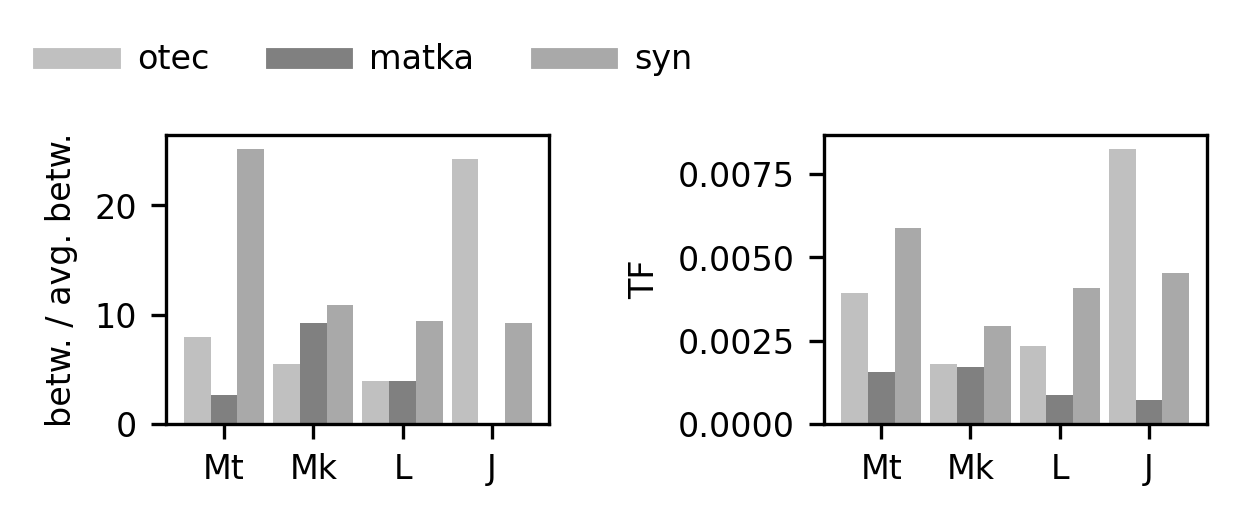

In [451]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.25, 1.8), tight_layout=True)

# betweenness
for word, loc, color in zip(
    ["otec", "matka", "syn"],
    [-0.3, 0, 0.3],
    ["#C0C0C0", "#808080", "#A9A9A9"]):
    ax1.bar(x=np.array(range(0,4)) + loc, height=key_terms_betw_df["betw_" + word], width=0.3,color=color)
ax1.set_xticks(range(0,4))
ax1.set_xticklabels(evangelia)
ax1.set_ylabel("betw. / avg. betw.")
    

for word, loc, color in zip(
    ["otec", "matka", "syn"],
    [-0.3, 0, 0.3],
    ["#C0C0C0", "#808080", "#A9A9A9"]):
    ax2.bar(x=np.array(range(0,4)) + loc, height=key_terms_betw_df["freq_" + word], width=0.3,color=color)
ax2.set_xticks(range(0,4))
ax2.set_xticklabels(evangelia)
ax2.set_ylabel("TF")
    

markers = [plt.Line2D([0,0],[0,0],color=color, linewidth=5) for color in ["#C0C0C0", "#808080", "#A9A9A9"]]
ax1.legend(markers, ["otec", "matka", "syn"], numpoints=0.5,  fontsize=8, ncol=3, bbox_to_anchor=(-0.4,1.1), loc="lower left", frameon=False)


In [452]:
fig.savefig("figures/evangelia_betw_vs_tf.png")
fig.savefig("figures/evangelia_betw_vs_tf.eps")

# Greek text


In [394]:
### we want the terms with translation
### Dodson's dictionary parsed using Beautiful Soup
url = "https://raw.githubusercontent.com/biblicalhumanities/Dodson-Greek-Lexicon/master/dodson.xml"
primary_dict = {}
page = urlopen(url)
soup = BeautifulSoup(page)
for element in soup.find_all("entry"):
    primary_dict.update({element.orth.get_text().partition(",")[0].lower() : element.find("def").get_text()})


### morphesus dictionary parsed using ETREE
urls = ["https://raw.githubusercontent.com/gcelano/MorpheusGreekUnicode/master/MorpheusGreek1-319492.xml", "https://raw.githubusercontent.com/gcelano/MorpheusGreekUnicode/master/MorpheusGreek319493-638984.xml", "https://raw.githubusercontent.com/gcelano/MorpheusGreekUnicode/master/MorpheusGreek638985-958476.xml"]
morpheus_dict = {}
for url in urls:
    page = urlopen(url)
    tree = ET.parse(page)
    root = tree.getroot()
    for element in root.iter("t"):
        morpheus_dict.update({element.find("l").text.lower() : element.find("s").text})

def translator_short(term):
    """Replace "GREEKWORD" by "GREEKWORD (english translation)"""
    term = unicodedata.normalize("NFC", term)
    try:
        if term in primary_dict:
            translation = primary_dict.get(term)
            translation = (", ").join(translation.split(", ")[:2])
            term_with_translation = term+ " (" + translation +")"
        else: 
            if term in morpheus_dict:
                term_with_translation = term+ " (" + morpheus_dict.get(term) +")"
            else:
                term_with_translation = term
        return term_with_translation
    except:
        pass


def list_of_meanings(term):
    """return meanings"""
    term = unicodedata.normalize("NFC", term)
    try:
        if term in primary_dict:
            translation = primary_dict.get(term).split(", ")
        else: 
            if term in morpheus_dict:
                translation = morpheus_dict.get(term).split(", ")
            else:
                translation = [] 
        return translation
    except:
        pass

In [387]:
### we upload a preprocessed dataset from sciencedata.dk. Accessible without any password etc.
LG_data_cleaned = sddk.read_file("https://sciencedata.dk/shared/56f7e75a7162c6e9eb756e7b8b4ed880?download", "df")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [388]:
LG_data_cleaned = LG_data_cleaned[(LG_data_cleaned["century"].notnull()) & (LG_data_cleaned["century"] < 4)]
LG_data_cleaned.head(5)

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data
0,Lucianus Samosatenus,De saltatione,tlg0062.tlg045.1st1K-grc1,pagan,1.5,"[λυκινος, κάρα, δεινός, τις, κατηγορία, πολύς,...","[λυκινος, κάρα, δεινός, τις, κατηγορία, πολύς,...","[[λυκινος, κάρα, δεινός, τις, κατηγορία, πολύς...","ΛΥΚΙΝΟΣ 1 Ἐπεὶ τοίνυν , ὦ Κράτων , δεινήν τινα...",8031,3497,2297,"[207, 16.8937198068, 80, 10.8087596065]"
1,Lucianus Samosatenus,Deorum concilium,tlg0062.tlg050.1st1K-grc1,pagan,1.5,"[ζευς, μηκέτι, τονθορύζω, θεός, γωνία, συστρέφ...","[ζευς, μηκέτι, θεός, γωνία, οὖς, πολύς, ἀνάξιο...","[[ζευς, μηκέτι, τονθορύζω, θεός, γωνία, συστρέ...","ΖΕΥΣ 1 Μηκέτι τονθορύζετε , ὦ θεοί , μηδὲ κατὰ...",2166,912,557,"[63, 14.4761904762, 84, 15.7155843619]"
2,Plutarch,Theseus,tlg0007.tlg001.perseus-grc2,pagan,1.5,"[γεωγραφία, σόσσιος, σενεκίων, ἱστορικός, διαφ...","[γεωγραφία, σόσσιος, σενεκίων, ἱστορικός, γνῶσ...","[[γεωγραφία, σόσσιος, σενεκίων, ἱστορικός, δια...","ὥσπερ ἐν ταῖς γεωγραφίαις , ὦ Σόσσιε Σενεκίων ...",8306,4028,2412,"[249, 16.1767068273, 70, 10.2169685024]"
3,Xenophon,Apology,tlg0032.tlg005.perseus-grc2,pagan,-3.5,"[σωκράτης, ἄξιος, δοκέω, εἰμί, μιμνήσκω, καλέω...","[σωκράτης, ἄξιος, δίκη, ἀπολογία, τελευτή, βίο...","[[σωκράτης, ἄξιος, δοκέω, εἰμί, μιμνήσκω, καλέ...",Σωκράτους δὲ ἄξιόν μοι δοκεῖ εἶναι μεμνῆσθαι κ...,2250,908,463,"[54, 16.8148148148, 115, 15.5326109442]"
6,Lysias,For Polystratus,tlg0540.tlg020.perseus-grc2,pagan,-4.5,"[δοκέω, χρή, ὀργίζω, ὄνομα, τετρακόσιοι, ἔργον...","[ὄνομα, τετρακόσιοι, ἔργον, πόλις, κακός, εὔνο...","[[δοκέω, χρή, ὀργίζω, ὄνομα, τετρακόσιοι, ἔργο...",οὔ μοι δοκεῖ χρῆναι ὀργίζεσθαι ὑμᾶς τῷ ὀνόματι...,2215,866,424,"[79, 10.9620253165, 28, 6.5011061142]"


In [461]:
LAGT = pd.read_json("https://zenodo.org/record/4971946/files/LAGT_v1-0.json?download=1")
LAGT.head(5)

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,tlg_epithet,clean_string,n_sentences,lemmatized_sentences
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica,38822,tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,Epici/-ae,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",3252,"[[ἄρχω, Φοῖβος, παλαιγενής, κλέος, φώς, μιμνήσ..."
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War,150118,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,Historici/-ae,Θουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶν...,6068,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ..."
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers,110763,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,Biographi,Τὸ τῆς φιλοσοφίας ἔργον ἔνιοί φασιν ἀπὸ βαρβάρ...,10245,"[[φιλοσοφία, ἔργον, ἔνιοι, φημί, βάρβαρος, ἄρχ..."
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls,19200,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,Bucolici,"̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ πίτυς αἰπόλε τήνα,...",1982,"[[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, τῆνος, πηγή,..."
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams,1734,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,Bucolici,τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυκνος ἐκείνα ἕ...,152,"[[ῥόδον, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλ..."


In [462]:
len(LAGT)

1457

In [463]:
LAGT["wordcount"].sum()

31248866

In [464]:
LAGT_metadata = pd.read_csv("data/LAGT_metadata.csv")
provenience_dict = dict(zip(LAGT_metadata["filename"],  LAGT_metadata["provenience"]))

In [465]:
# update provencience on the basis of manual coding
LAGT["provenience"] = LAGT["filename"].apply(lambda x: provenience_dict[x])

In [466]:
LAGT = LAGT[LAGT["provenience"].isin(["christian", "pagan"])]
len(LAGT)

1346

In [467]:
LAGT = LAGT[LAGT["date_avr"]<=4]
len(LAGT)

1218

In [468]:
LAGT["wordcount"].sum()

20227339

In [469]:
def flat_lemmata(sentences):
    lemmata = [word for sent in sentences for word in sent]
    return lemmata
LAGT["lemmata"] = LAGT["lemmatized_sentences"].apply(flat_lemmata)

LAGT["lemmata_wordcount"] = LAGT["lemmata"].apply(len)
LAGT["lemmata_wordcount"].sum() # previously we had 13925726, then 13713183, 14373580, 14342245

9318333

In [470]:
def grouping_gnt(author_id):
    if author_id == "tlg0031a":
        author_id = "tlg0031matt"
    if author_id == "tlg0031b":
        author_id = "tlg0031mark"
    if re.match("tlg0031\w?$", author_id):
        return "tlg0031rest"
    else:
        return author_id
new_author_ids = LAGT["author_id"].apply(grouping_gnt)

LAGT["author_id"] = new_author_ids

# Networks on the level of authors


In [460]:
LAGT[LAGT["author_id"].str.contains("tlg0086")]

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,tlg_epithet,clean_string,n_sentences,lemmatized_sentences,lemmata,lemmata_wordcount
685,tlg0086.tlg001.1st1K-grc2.xml,Aristotle,Aristotelis Analytica Priora et Posteriora,59614,tlg0086,tlg0086.tlg001,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Philosophici/-ae,Πρῶτον εἰπεῖν περὶ τί καὶ τίνος ἐστὶν ἡ σκέψις...,3710,"[[πρῶτος, λέγω, εἰμί, σκέψις, ἀπόδειξις, ἐπιστ...","[πρῶτος, λέγω, εἰμί, σκέψις, ἀπόδειξις, ἐπιστή...",24680
686,tlg0086.tlg002.1st1K-grc2.xml,Aristotle,De anima,20912,tlg0086,tlg0086.tlg002,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Philosophici/-ae,Τῶν καλῶν καὶ τιμίων τὴν εἴδησιν ὑπολαμβάνοντε...,1317,"[[καλός, τίμιος, εἶδος, ὑπολαμβάνω, ἕτερος, ἕτ...","[καλός, τίμιος, εἶδος, ὑπολαμβάνω, ἕτερος, ἕτε...",9395
687,tlg0086.tlg003.perseus-grc1.xml,Aristotle,Athenian Constitution,16459,tlg0086,tlg0086.tlg003,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Philosophici/-ae,Ἀθηναῖοι τὸ μὲν ἐξ ἀρχῆς ἐχρῶντο βασιλείᾳ. συν...,916,"[[Ἀθηναῖος, ἀρχή, χράω, βασίλειος], [συνοικησά...","[Ἀθηναῖος, ἀρχή, χράω, βασίλειος, συνοικησάντο...",8088
688,tlg0086.tlg005.1st1K-grc1.xml,Aristotle,De caelo,30794,tlg0086,tlg0086.tlg005,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Philosophici/-ae,Ἡ περὶ φύσεως ἐπιστήμη σχεδὸν ἡ πλείστη φαίνετ...,2276,"[[φύσις, ἐπιστήμη, πλεῖστος, φαίνω, σῶμα, μέγε...","[φύσις, ἐπιστήμη, πλεῖστος, φαίνω, σῶμα, μέγεθ...",13437
689,tlg0086.tlg006.1st1K-grc1.xml,Aristotle,Categoriae,10316,tlg0086,tlg0086.tlg006,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Philosophici/-ae,"ὉΜΩΝΥΜΑ λέγεται ὧν ὄνομα μόνον κοινόν, ὁ δὲ κα...",660,"[[ὁμώνυμος, λέγω, ὄνομα, μόνος, κοινός, ὄνομα,...","[ὁμώνυμος, λέγω, ὄνομα, μόνος, κοινός, ὄνομα, ...",4678
690,tlg0086.tlg008.1st1K-grc1.xml,Aristotle,De divinatione per somnum,1194,tlg0086,tlg0086.tlg008,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Philosophici/-ae,Περὶ δὲ τῆς μαντικῆς τῆς ἐν τοῖς ὕπνοις γινομέ...,68,"[[μαντικός, ὕπνος, γίγνομαι, λέγω, συμβαίνω, ἐ...","[μαντικός, ὕπνος, γίγνομαι, λέγω, συμβαίνω, ἐν...",549
691,tlg0086.tlg009.perseus-grc1.xml,Aristotle,Eudemian Ethics (Greek). Machine readable text,26345,tlg0086,tlg0086.tlg009,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Philosophici/-ae,ὁ μὲν ἐν Δήλῳ παρὰ τῷ θεῷ τὴν αὑτοῦ γνώμην ἀπ...,1683,"[[δῆλος, θεός, ἑαυτοῦ, γνώμη, ἀποφηνάμενος, συ...","[δῆλος, θεός, ἑαυτοῦ, γνώμη, ἀποφηνάμενος, συγ...",11564
692,tlg0086.tlg010.perseus-grc1.xml,Aristotle,Nicomachean Ethics,56620,tlg0086,tlg0086.tlg010,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Philosophici/-ae,"πᾶσα τέχνη καὶ πᾶσα μέθοδος, ὁμοίως δὲ πρᾶξίς ...",3920,"[[τέχνη, πᾶς, μέθοδος, πρᾶξις, προαίρεσις, ἀγα...","[τέχνη, πᾶς, μέθοδος, πρᾶξις, προαίρεσις, ἀγαθ...",25082
693,tlg0086.tlg013.1st1K-grc2.xml,Aristotle,De generatione et corruptione,16914,tlg0086,tlg0086.tlg013,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Philosophici/-ae,Περὶ δὲ γενέσεως καὶ φθορᾶς τῶν φύσει γινομένω...,1215,"[[γένεσις, φθορά, φύσις, γίγνομαι, φθειρομένων...","[γένεσις, φθορά, φύσις, γίγνομαι, φθειρομένων,...",7430
694,tlg0086.tlg014.1st1K-grc1.xml,Aristotle,Historia animalium,93923,tlg0086,tlg0086.tlg014,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Philosophici/-ae,ΤΩΝ ἐν τοῖς ζῴοις μορίων τὰ μέν ἐστιν ἀσύνθετα...,6337,"[[ζῷον, μόριον, εἰμί, ἀσύνθετος, ὅσος, διαιρέω...","[ζῷον, μόριον, εἰμί, ἀσύνθετος, ὅσος, διαιρέω,...",43967


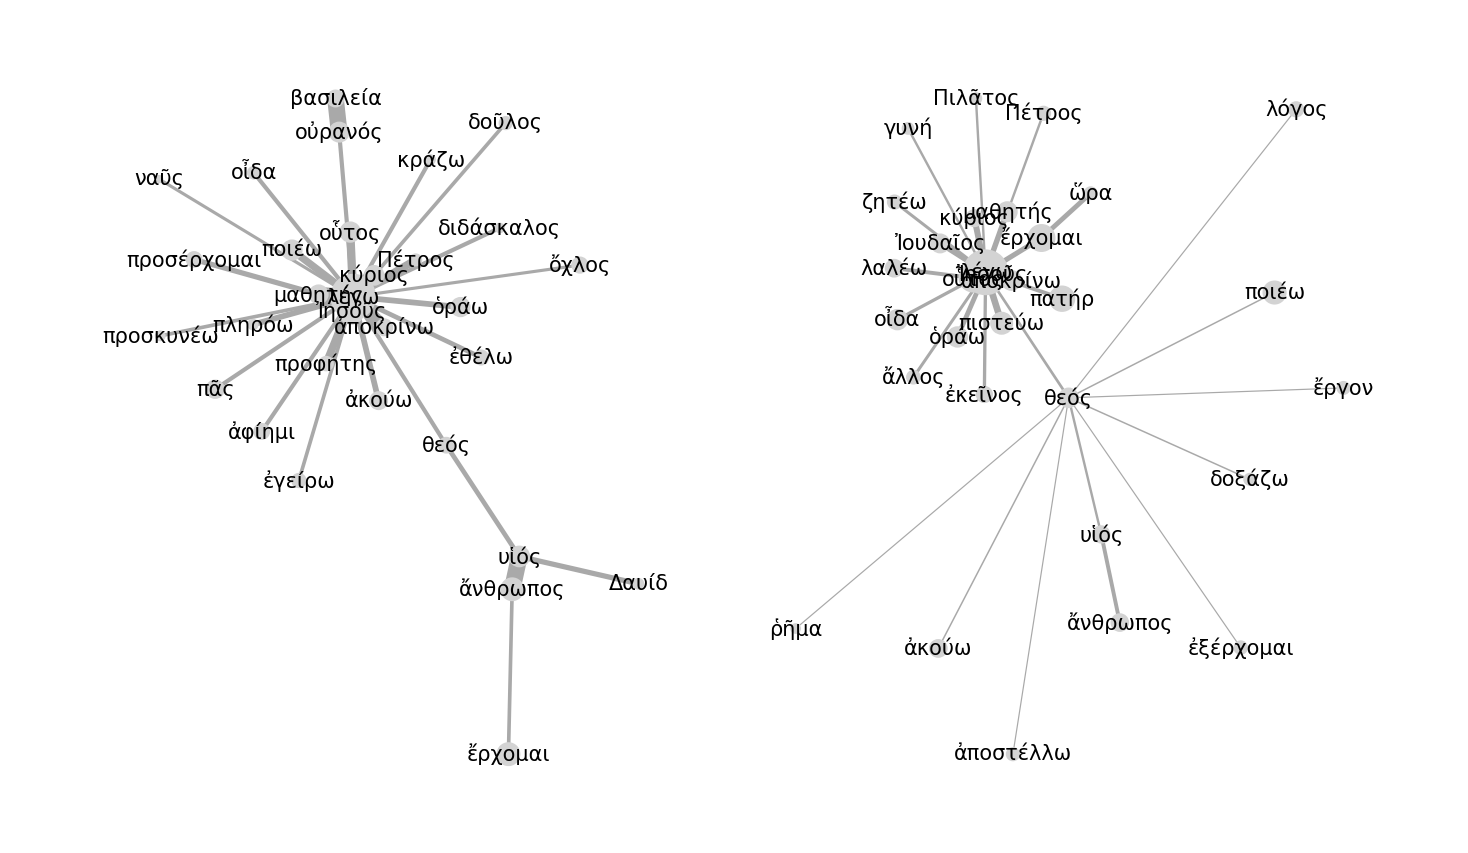

In [481]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.25, 2.2))
ego_network_standard(LAGT, "lemmata", "author_id", "tlg0031matt", 'θεός', threshold=2, stopwords=["εἰμί"], ax=ax1) # "θεός"
ego_network_standard(LAGT, "lemmata", "doc_id", "tlg0031.tlg004", 'θεός', threshold=2, stopwords=["εἰμί"], ax=ax2) # "θεός"
fig.tight_layout(pad=-2)

In [482]:
fig.savefig("figures/network_Mt+J_theos.png", bbox_inches='tight', pad_inches=0)
fig.savefig("figures/network_Mt+J_theos.eps", bbox_inches='tight', pad_inches=0)

In [511]:
def ego_network_closest(df, data_col, select_col, select_col_val, term, num_of_neighbours, stopwords=["εἰμί"]):
    if isinstance(df[data_col].tolist()[0][0], str): # if flat list, i.e. list of lemmata
        # form bigrams:
        network = network_from_df_lemmata_list_col(df, data_col, select_col, select_col_val, 500, 1, stopwords=stopwords)
    else:
        network = network_from_df_sentences_col(df, data_col, select_col, select_col_val, 500, 1, stopwords=stopwords)
    length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
    length_sorted = sorted(length.items(), key=lambda x:x[1])[1:num_of_neighbours+1]
    length_sorted_trans = [(translator_short(tup[0]), round(tup[1], 3)) for tup in length_sorted]
    return length_sorted_trans

iliad = ego_network_closest(LAGT, "lemmata", "doc_id", "tlg0012.tlg001", 'θεός', 5)
phaedo = ego_network_closest(LAGT, "lemmata", "doc_id", "tlg0059.tlg004", 'θεός', 5)
john = ego_network_closest(LAGT, "lemmata", "doc_id", "tlg0031.tlg004", 'θεός', 5)

In [513]:
nearests_df = pd.concat([pd.DataFrame(iliad), pd.DataFrame(phaedo), pd.DataFrame(john)],  axis=1)
nearests_df.head(5)

,0,1,0,1,0,1
0,"πᾶς (all, the whole)",0.034,"οἴομαι (to suppose, think, deem, imagine)",0.500,"λέγω (I say, speak)",0.111
1,"ἀνήρ (a male human being, a man)",0.036,"πρῶτος (first, before)",0.500,Ἰησοῦς,0.120
2,"ἄλλος (other, another)",0.038,"ἐθέλω (to will, wish, purpose)",0.500,"υἱός (a son, descendent)",0.125
3,"ἀθάνατος (undying, immortal)",0.050,"ἔχω (I have, hold)",0.500,"οὗτος (this, he)",0.128
4,"ἄναξ (a lord, master)",0.054,"λέγω (I say, speak)",0.562,"ἀποκρίνω (to separate, set apart)",0.145


In [515]:
nearests_df.columns=["Homer, Iliad", "dist", "Plato, Phaedo", "dist", "Gospel of John", "dist"]
nearests_df

,"Homer, Iliad",dist,"Plato, Phaedo",dist,Gospel of John,dist
0,"πᾶς (all, the whole)",0.034,"οἴομαι (to suppose, think, deem, imagine)",0.500,"λέγω (I say, speak)",0.111
1,"ἀνήρ (a male human being, a man)",0.036,"πρῶτος (first, before)",0.500,Ἰησοῦς,0.120
2,"ἄλλος (other, another)",0.038,"ἐθέλω (to will, wish, purpose)",0.500,"υἱός (a son, descendent)",0.125
3,"ἀθάνατος (undying, immortal)",0.050,"ἔχω (I have, hold)",0.500,"οὗτος (this, he)",0.128
4,"ἄναξ (a lord, master)",0.054,"λέγω (I say, speak)",0.562,"ἀποκρίνω (to separate, set apart)",0.145


In [516]:
nearests_df.to_csv("data/nearest_df.csv", index=False)

# Moral Foundations Dictionary

In [520]:
moral_dictionary_full_df = pd.read_csv("data/moral_dictionary_full_df.csv")
moral_dictionary_full_df.tail(5)

,raw,category,term,var1
331,immoral*\t\t11,11,immoral*,False
332,bad\t\t\t11,11,bad,False
333,offend*\t\t\t11,11,offend*,False
334,offensive*\t\t11,11,offensive*,False
335,transgress*\t\t11,11,transgress*,False


In [521]:
moral_indicators = moral_dictionary_full_df[moral_dictionary_full_df["var1"]==True]["term"].tolist()
moral_indicators = [term.replace(" ", "").partition("*")[0] for term in moral_indicators] 
print(moral_indicators)

['righteous', 'moral', 'ethic', 'value', 'upstanding', 'good', 'goodness', 'principle', 'blameless', 'exemplary', 'lesson', 'canon', 'doctrine', 'noble', 'worth', 'ideal', 'praiseworthy', 'commendable', 'character', 'proper', 'laudable', 'correct']


In [522]:
len(moral_indicators)

22

In [523]:
translation_variants = ["righteousness", "goodness", "bad", "shit"]
for term in translation_variants:
  if term.startswith(tuple(moral_indicators)):
    print("yes")
  else: print("no")

yes
yes
no
no


# Networks on the level of individual documents

# Testing with sample data

In [527]:
### we will test our algorithms on a data sample of 10 documents:
#random.seed( 30 ) ### firstly generated on Oct 9, 15:24
randomly_selected_works = [random.randint(0,len(LAGT)) for i in range(10)]
LG_testing_sample = LAGT.iloc[randomly_selected_works]
###set_with_dataframe(sh.add_worksheet("LG_sample_FIXED", cols=1, rows=1), LG_testing_sample.drop(["lemmata", "string"], axis=1))
LG_testing_sample

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,tlg_epithet,clean_string,n_sentences,lemmatized_sentences,lemmata,lemmata_wordcount
369,tlg0027.tlg004.perseus-grc1.xml,Andocides,Against Alcibiades,3104,tlg0027,tlg0027.tlg004,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",NaN,pagan,Oratores,οὐκ ἐν τῷ παρόντι μόνον γιγνώσκω τῶν πολιτικῶν...,345,"[[πάρειμι, μόνος, γιγνώσκω, πολιτικός, πρᾶγμα,...","[πάρειμι, μόνος, γιγνώσκω, πολιτικός, πρᾶγμα, ...",1523
611,tlg0062.tlg039.perseus-grc1.xml,Lucian,Imagines,3233,tlg0062,tlg0062.tlg039,A.D. 2,1.5,{'1.5': 1},1.5,pagan,Sophistae,ἀλλʼ ἧ Ἰθίούτόν τι βττασγον οι τὴν Γοργὼ ἰδόν...,172,"[[ἰθίούτόν, βττασγον, ὄις, Γοργώ, ὁράω, πάσχω,...","[ἰθίούτόν, βττασγον, ὄις, Γοργώ, ὁράω, πάσχω, ...",1536
278,tlg0014.tlg041.perseus-grc2.xml,Demosthenes,πρὸς Σπουδίαν ὑπὲρ προικός,1967,tlg0014,tlg0014.tlg041,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Oratores,"ἀδελφὰς ἔχομεν, ὦ ἄνδρες δικασταί, γυναῖκας ἐγ...",108,"[[ἀδελφή, ἔχω, ἀνήρ, δικαστής, γυνή, σπουδίας,...","[ἀδελφή, ἔχω, ἀνήρ, δικαστής, γυνή, σπουδίας, ...",965
406,tlg0031.tlg022.perseus-grc2.xml,None,New Testament - 2 Peter,1095,tlg0031rest,tlg0031.tlg022,A.D. 1,0.5,{'0.5': 1},0.5,christian,[],ΣΙΜΩΝ ΠΕΤΡΟΣ δοῦλος καὶ ἀπόστολος Ἰησοῦ Χριστ...,42,"[[σιμός, πέτρος, δοῦλος, ἀπόστολος, Ἰησοῦς, Χρ...","[σιμός, πέτρος, δοῦλος, ἀπόστολος, Ἰησοῦς, Χρι...",595
419,tlg0032.tlg008.perseus-grc2.xml,Xenophon,Hiero,5969,tlg0032,tlg0032.tlg008,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,Historici/-ae,Σιμωνίδης ὁ ποιητὴς ἀφίκετό ποτε πρὸς Ἱέρωνα τ...,321,"[[Σιμωνίδης, ποιητής, ἀφικνέομαι, Ἱέρων, τύραν...","[Σιμωνίδης, ποιητής, ἀφικνέομαι, Ἱέρων, τύρανν...",2864
1044,tlg0627.tlg006.perseus-grc1.xml,Hippocrates,Of the Epidemics,10889,tlg0627,tlg0627.tlg006,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,Medici,ἐν Θάσῳ φθινοπώρου περὶ ἰσημερίην καὶ ὑπὸ πληι...,1216,"[[Θάσος, φθινόπωρον, ἰσημερίην, πληιάδα, ὕδωρ,...","[Θάσος, φθινόπωρον, ἰσημερίην, πληιάδα, ὕδωρ, ...",6782
1338,tlg2042.tlg084.opp-grc1.xml,Origenes,Fragmenta In Jeremiam (E Philocalia),998,tlg2042,tlg2042.tlg084,A.D. 2-3,2.0,"{'1.5': 0.5, '2.5': 0.5}",2.5,christian,Theologici,{Ὥσπερ δὲ πάντα τὰ τοῦ θεοῦ δωρήματα εἰς ὑπερβ...,97,"[[θεός, δώρημα, ὑπερβολή, μέγας, εἰμί, θνητός,...","[θεός, δώρημα, ὑπερβολή, μέγας, εἰμί, θνητός, ...",411
438,tlg0036.tlg003.perseus-grc1.xml,Bion of Phlossa,Fragmenta,860,tlg0036,tlg0036.tlg003,2 B.C.,-1.5,{'-1.5': 1},NaN,pagan,Bucolici,Εἴαρος ὦ Μύρσων ἢ χείματος ἢ φθινοπώρω ἢ θέρεο...,112,"[[ἔαρ, μύρσων, χεῖμα, φθινοπώρω, θέρος, ἡδύς],...","[ἔαρ, μύρσων, χεῖμα, φθινοπώρω, θέρος, ἡδύς, π...",536
165,tlg0010.tlg002.perseus-grc2.xml,Isocrates,Against Callimachus,3598,tlg0010,tlg0010.tlg002,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,Oratores,εἰ μὲν καὶ ἄλλοι τινὲς ἦσαν ἠγωνισμένοι τοιαύ...,177,"[[ἄλλος, εἰμί, ἠγωνισμένοι, τοιοῦτος, παραγραφ...","[ἄλλος, εἰμί, ἠγωνισμένοι, τοιοῦτος, παραγραφή...",1746
1168,tlg1431.tlg003.1st1K-grc1.xml,Hipparchus,In Arati et Eudoxi phaenomena commentariorum l...,33093,tlg1431,tlg1431.tlg003,2 B.C.,-1.5,{'-1.5': 1},NaN,pagan,Geographi,Ἵππαρχος Αἰσχρίωνι χαίρειν. Ἡδέως ἐπέγνων διὰ ...,3276,"[[Ἵππαρχος, αἰσχρίωνι, χαίρω], [ἐπιγιγνώσκω, ἐ...","[Ἵππαρχος, αἰσχρίωνι, χαίρω, ἐπιγιγνώσκω, ἐπισ...",14521


In [ ]:
def ego_network_closest(df, data_col, select_col, select_col_val, term, num_of_neighbours, stopwords=["εἰμί"]):
    if isinstance(df[data_col].tolist()[0][0], str): # if flat list, i.e. list of lemmata
        # form bigrams:
        network = network_from_df_lemmata_list_col(df, data_col, select_col, select_col_val, 500, 1, stopwords=stopwords)
    else:
        network = network_from_df_sentences_col(df, data_col, select_col, select_col_val, 500, 1, stopwords=stopwords)
    length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
    length_sorted = sorted(length.items(), key=lambda x:x[1])[1:num_of_neighbours+1]
    length_sorted_trans = [(translator_short(tup[0]), round(tup[1], 3)) for tup in length_sorted]
    return length_sorted_trans

In [549]:
def ego_network_list_from_list(lemmata_list, term, num_of_neighbours):
    try:
        network = network_from_lemmata_list(lemmata_list, 500, 1)
        length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
        length_sorted = sorted(length.items(), key=lambda x:x[1])[1:num_of_neighbours+1]
        length_sorted_trans = [(tup[0], list_of_meanings(tup[0]), round(tup[1], 3)) for tup in length_sorted]
        return length_sorted_trans
    except:
        return []
def generate_ego_network_data(lemmata):
    return ego_network_list_from_list(lemmata, "θεός", 30)

In [550]:
LG_testing_sample["theos_egonetwork"] = LG_testing_sample["lemmata"].apply(generate_ego_network_data)
LG_testing_sample = LG_testing_sample.loc[LG_testing_sample["theos_egonetwork"].apply(lambda x: len(x) > 0)]
LG_testing_sample

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,tlg_epithet,clean_string,n_sentences,lemmatized_sentences,lemmata,lemmata_wordcount,theos_egonetwork,moral_terms,moral_count
611,tlg0062.tlg039.perseus-grc1.xml,Lucian,Imagines,3233,tlg0062,tlg0062.tlg039,A.D. 2,1.5,{'1.5': 1},1.5,pagan,Sophistae,ἀλλʼ ἧ Ἰθίούτόν τι βττασγον οι τὴν Γοργὼ ἰδόν...,172,"[[ἰθίούτόν, βττασγον, ὄις, Γοργώ, ὁράω, πάσχω,...","[ἰθίούτόν, βττασγον, ὄις, Γοργώ, ὁράω, πάσχω, ...",1536,"[(ζητέω, [I seek, search for, desire], 1.0), (...","[καλός, χρή]",2
278,tlg0014.tlg041.perseus-grc2.xml,Demosthenes,πρὸς Σπουδίαν ὑπὲρ προικός,1967,tlg0014,tlg0014.tlg041,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Oratores,"ἀδελφὰς ἔχομεν, ὦ ἄνδρες δικασταί, γυναῖκας ἐγ...",108,"[[ἀδελφή, ἔχω, ἀνήρ, δικαστής, γυνή, σπουδίας,...","[ἀδελφή, ἔχω, ἀνήρ, δικαστής, γυνή, σπουδίας, ...",965,"[(μανθάνω, [I learn, ascertain], 1.0), (νέω, [...",[],0
406,tlg0031.tlg022.perseus-grc2.xml,None,New Testament - 2 Peter,1095,tlg0031rest,tlg0031.tlg022,A.D. 1,0.5,{'0.5': 1},0.5,christian,[],ΣΙΜΩΝ ΠΕΤΡΟΣ δοῦλος καὶ ἀπόστολος Ἰησοῦ Χριστ...,42,"[[σιμός, πέτρος, δοῦλος, ἀπόστολος, Ἰησοῦς, Χρ...","[σιμός, πέτρος, δοῦλος, ἀπόστολος, Ἰησοῦς, Χρι...",595,"[(δικαιοσύνη, [justice, justness, righteousnes...",[δικαιοσύνη],1
419,tlg0032.tlg008.perseus-grc2.xml,Xenophon,Hiero,5969,tlg0032,tlg0032.tlg008,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,Historici/-ae,Σιμωνίδης ὁ ποιητὴς ἀφίκετό ποτε πρὸς Ἱέρωνα τ...,321,"[[Σιμωνίδης, ποιητής, ἀφικνέομαι, Ἱέρων, τύραν...","[Σιμωνίδης, ποιητής, ἀφικνέομαι, Ἱέρων, τύρανν...",2864,"[(γίγνομαι, [gi-geno], 1.0), (δοκέω, [I think,...","[καλός, ἀγαθός]",2
1338,tlg2042.tlg084.opp-grc1.xml,Origenes,Fragmenta In Jeremiam (E Philocalia),998,tlg2042,tlg2042.tlg084,A.D. 2-3,2.0,"{'1.5': 0.5, '2.5': 0.5}",2.5,christian,Theologici,{Ὥσπερ δὲ πάντα τὰ τοῦ θεοῦ δωρήματα εἰς ὑπερβ...,97,"[[θεός, δώρημα, ὑπερβολή, μέγας, εἰμί, θνητός,...","[θεός, δώρημα, ὑπερβολή, μέγας, εἰμί, θνητός, ...",411,"[(σοφία, [wisdom], 0.25), (λόγος, [a word, spe...",[],0
438,tlg0036.tlg003.perseus-grc1.xml,Bion of Phlossa,Fragmenta,860,tlg0036,tlg0036.tlg003,2 B.C.,-1.5,{'-1.5': 1},NaN,pagan,Bucolici,Εἴαρος ὦ Μύρσων ἢ χείματος ἢ φθινοπώρω ἢ θέρεο...,112,"[[ἔαρ, μύρσων, χεῖμα, φθινοπώρω, θέρος, ἡδύς],...","[ἔαρ, μύρσων, χεῖμα, φθινοπώρω, θέρος, ἡδύς, π...",536,"[(δέχομαι, [I take, receive, accept, welcome],...","[ἐσθλός, καλός]",2
165,tlg0010.tlg002.perseus-grc2.xml,Isocrates,Against Callimachus,3598,tlg0010,tlg0010.tlg002,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,Oratores,εἰ μὲν καὶ ἄλλοι τινὲς ἦσαν ἠγωνισμένοι τοιαύ...,177,"[[ἄλλος, εἰμί, ἠγωνισμένοι, τοιοῦτος, παραγραφ...","[ἄλλος, εἰμί, ἠγωνισμένοι, τοιοῦτος, παραγραφή...",1746,"[(τιμωρία, [punishment, penalty], 1.0), (ἐξελέ...",[],0


In [551]:
def moral_terms_selector(row):
  moral_terms = []
  for element in row["theos_egonetwork"]:
    decisions = []
    try:
      for translation_variant in element[1]:
        if translation_variant.startswith(tuple(moral_indicators)):
          decisions.append("yes")
        else: 
          decisions.append("no")
    except: pass
    if "yes" in decisions: 
      moral_terms.append(element[0])
  return moral_terms

In [552]:
LG_testing_sample["moral_terms"] =  LG_testing_sample.apply(lambda row: moral_terms_selector(row), axis=1)
LG_testing_sample["moral_count"] =  LG_testing_sample.apply(lambda row: len(row["moral_terms"]), axis=1)
LG_testing_sample

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,tlg_epithet,clean_string,n_sentences,lemmatized_sentences,lemmata,lemmata_wordcount,theos_egonetwork,moral_terms,moral_count
611,tlg0062.tlg039.perseus-grc1.xml,Lucian,Imagines,3233,tlg0062,tlg0062.tlg039,A.D. 2,1.5,{'1.5': 1},1.5,pagan,Sophistae,ἀλλʼ ἧ Ἰθίούτόν τι βττασγον οι τὴν Γοργὼ ἰδόν...,172,"[[ἰθίούτόν, βττασγον, ὄις, Γοργώ, ὁράω, πάσχω,...","[ἰθίούτόν, βττασγον, ὄις, Γοργώ, ὁράω, πάσχω, ...",1536,"[(ζητέω, [I seek, search for, desire], 1.0), (...","[καλός, χρή]",2
278,tlg0014.tlg041.perseus-grc2.xml,Demosthenes,πρὸς Σπουδίαν ὑπὲρ προικός,1967,tlg0014,tlg0014.tlg041,4 B.C.,-3.5,{'-3.5': 1},-3.5,pagan,Oratores,"ἀδελφὰς ἔχομεν, ὦ ἄνδρες δικασταί, γυναῖκας ἐγ...",108,"[[ἀδελφή, ἔχω, ἀνήρ, δικαστής, γυνή, σπουδίας,...","[ἀδελφή, ἔχω, ἀνήρ, δικαστής, γυνή, σπουδίας, ...",965,"[(μανθάνω, [I learn, ascertain], 1.0), (νέω, [...",[],0
406,tlg0031.tlg022.perseus-grc2.xml,None,New Testament - 2 Peter,1095,tlg0031rest,tlg0031.tlg022,A.D. 1,0.5,{'0.5': 1},0.5,christian,[],ΣΙΜΩΝ ΠΕΤΡΟΣ δοῦλος καὶ ἀπόστολος Ἰησοῦ Χριστ...,42,"[[σιμός, πέτρος, δοῦλος, ἀπόστολος, Ἰησοῦς, Χρ...","[σιμός, πέτρος, δοῦλος, ἀπόστολος, Ἰησοῦς, Χρι...",595,"[(δικαιοσύνη, [justice, justness, righteousnes...",[δικαιοσύνη],1
419,tlg0032.tlg008.perseus-grc2.xml,Xenophon,Hiero,5969,tlg0032,tlg0032.tlg008,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,Historici/-ae,Σιμωνίδης ὁ ποιητὴς ἀφίκετό ποτε πρὸς Ἱέρωνα τ...,321,"[[Σιμωνίδης, ποιητής, ἀφικνέομαι, Ἱέρων, τύραν...","[Σιμωνίδης, ποιητής, ἀφικνέομαι, Ἱέρων, τύρανν...",2864,"[(γίγνομαι, [gi-geno], 1.0), (δοκέω, [I think,...","[καλός, ἀγαθός]",2
1338,tlg2042.tlg084.opp-grc1.xml,Origenes,Fragmenta In Jeremiam (E Philocalia),998,tlg2042,tlg2042.tlg084,A.D. 2-3,2.0,"{'1.5': 0.5, '2.5': 0.5}",2.5,christian,Theologici,{Ὥσπερ δὲ πάντα τὰ τοῦ θεοῦ δωρήματα εἰς ὑπερβ...,97,"[[θεός, δώρημα, ὑπερβολή, μέγας, εἰμί, θνητός,...","[θεός, δώρημα, ὑπερβολή, μέγας, εἰμί, θνητός, ...",411,"[(σοφία, [wisdom], 0.25), (λόγος, [a word, spe...",[],0
438,tlg0036.tlg003.perseus-grc1.xml,Bion of Phlossa,Fragmenta,860,tlg0036,tlg0036.tlg003,2 B.C.,-1.5,{'-1.5': 1},NaN,pagan,Bucolici,Εἴαρος ὦ Μύρσων ἢ χείματος ἢ φθινοπώρω ἢ θέρεο...,112,"[[ἔαρ, μύρσων, χεῖμα, φθινοπώρω, θέρος, ἡδύς],...","[ἔαρ, μύρσων, χεῖμα, φθινοπώρω, θέρος, ἡδύς, π...",536,"[(δέχομαι, [I take, receive, accept, welcome],...","[ἐσθλός, καλός]",2
165,tlg0010.tlg002.perseus-grc2.xml,Isocrates,Against Callimachus,3598,tlg0010,tlg0010.tlg002,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,Oratores,εἰ μὲν καὶ ἄλλοι τινὲς ἦσαν ἠγωνισμένοι τοιαύ...,177,"[[ἄλλος, εἰμί, ἠγωνισμένοι, τοιοῦτος, παραγραφ...","[ἄλλος, εἰμί, ἠγωνισμένοι, τοιοῦτος, παραγραφή...",1746,"[(τιμωρία, [punishment, penalty], 1.0), (ἐξελέ...",[],0


# Main measurement

In [611]:
LAGT = LAGT[LAGT["lemmata"].apply(len)>0]
LG_data_results = LAGT.copy()

In [612]:
LG_data_results["theos_count"] = LG_data_results["lemmata"].apply(lambda x: x.count("θεός"))
LG_data_results.sort_values("date_avr", inplace=True)
LG_data_results.head(5)

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,tlg_epithet,clean_string,n_sentences,lemmatized_sentences,lemmata,lemmata_wordcount,theos_count
202,tlg0012.tlg001.perseus-grc2.xml,Homer,Iliad (Greek). Machine readable text,111888,tlg0012,tlg0012.tlg001,8 B.C.,-7.5,{'-7.5': 1},-7.5,pagan,Epici/-ae,"μῆνιν ἄειδε θεὰ Πηληϊάδεω Ἀχιλῆος οὐλομένην, ...",8415,"[[μῆνις, ἀείδω, θεά, Πηλείδης, Ἀχιλλεύς, οὐλόμ...","[μῆνις, ἀείδω, θεά, Πηλείδης, Ἀχιλλεύς, οὐλόμε...",66880,403
203,tlg0012.tlg002.perseus-grc2.xml,Homer,Odyssey (Greek). Machine readable text,87177,tlg0012,tlg0012.tlg002,8 B.C.,-7.5,{'-7.5': 1},-7.5,pagan,Epici/-ae,"ἄνδρα μοι ἔννεπε, μοῦσα, πολύτροπον, ὃς μάλα π...",6729,"[[ἀνήρ, ἐνέπω, Μοῦσα, πολύτροπος, πολύς, πλάζω...","[ἀνήρ, ἐνέπω, Μοῦσα, πολύτροπος, πολύς, πλάζω,...",50450,371
204,tlg0012.tlg003.perseus-grc1.xml,Homer,Ἐπιγράμματα,757,tlg0012,tlg0012.tlg003,8 B.C.,-7.5,{'-7.5': 1},-7.5,pagan,Epici/-ae,"Αἰδεῖσθε ξενίων κεχρημένον ἠδὲ δόμοιο, οἳ πόλι...",72,"[[αἰδέομαι, ξένιος, χράω, δόμος, πόλις, αἰπειν...","[αἰδέομαι, ξένιος, χράω, δόμος, πόλις, αἰπεινό...",506,1
358,tlg0020.tlg002.perseus-grc2.xml,Hesiod,Works and Days (Greek). Machine readable text,5856,tlg0020,tlg0020.tlg002,8/7 B.C.?,-7.0,"{'-7.5': 0.5, '-6.5': 0.5}",-6.5,pagan,Epici/-ae,"μοῦσαι Πιερίηθεν ἀοιδῇσιν κλείουσαι δεῦτε, Δί...",490,"[[Μοῦσα, ἀοιδή, κλείουσαι, Ζεύς, ἐνέπω, σφέτερ...","[Μοῦσα, ἀοιδή, κλείουσαι, Ζεύς, ἐνέπω, σφέτερο...",3645,22
357,tlg0020.tlg001.perseus-grc2.xml,Hesiod,Theogony (Greek). Machine readable text,7039,tlg0020,tlg0020.tlg001,8/7 B.C.?,-7.0,"{'-7.5': 0.5, '-6.5': 0.5}",-6.5,pagan,Epici/-ae,"Μουσάων Ἑλικωνιάδων ἀρχώμεθʼ ἀείδειν, αἵθʼ Ἑλ...",438,"[[Μοῦσα, Ἑλικωνιάδες, ἄρχω, ἀείδω, Ἑλικών, ἔχω...","[Μοῦσα, Ἑλικωνιάδες, ἄρχω, ἀείδω, Ἑλικών, ἔχω,...",4611,83


In [613]:
len(LG_data_results[LG_data_results["theos_count"]>0])

862

In [614]:
%%time
### now we can apply the same upon whole dataset

### (1) generate the ego_networks:
LG_data_results["theos_egonetwork"] = LG_data_results["lemmata"].apply(generate_ego_network_data)

CPU times: user 5min 31s, sys: 1min 10s, total: 6min 41s
Wall time: 6min 41s


In [615]:
### (2) focus only on documents for which we have the egonetworks 
LG_data_results["theos_egonetwork_yes"] = LG_data_results["theos_egonetwork"].apply(lambda x: len(x) > 0)
len(LG_data_results[LG_data_results["theos_egonetwork_yes"]])

795

In [616]:
LG_data_results["lexicon_size"] = LG_data_results["lemmata"].apply(lambda x: len(set(x)))

In [617]:
len(LG_data_results[(LG_data_results["theos_egonetwork_yes"]) & (LG_data_results["lexicon_size"] >= 500)])

635

In [618]:
len(LG_data_results[(LG_data_results["theos_egonetwork_yes"]) & (LG_data_results["lexicon_size"] >= 500)]) / len(LG_data_results[LG_data_results["theos_egonetwork_yes"]])

0.7987421383647799

In [619]:
len(LG_data_results[(LG_data_results["theos_egonetwork_yes"]) & (LG_data_results["lexicon_size"] >= 300)]) / len(LG_data_results[LG_data_results["theos_egonetwork_yes"]])

0.9333333333333333

In [620]:
### (3) count the moral terms
LG_data_results["moral_terms"] =  LG_data_results.apply(lambda row: moral_terms_selector(row), axis=1)
LG_data_results["moral_count"] =  LG_data_results.apply(lambda row: len(row["moral_terms"]), axis=1)
LG_data_results.head(3)

,filename,author,title,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,...,n_sentences,lemmatized_sentences,lemmata,lemmata_wordcount,theos_count,theos_egonetwork,theos_egonetwork_yes,lexicon_size,moral_terms,moral_count
202,tlg0012.tlg001.perseus-grc2.xml,Homer,Iliad (Greek). Machine readable text,111888,tlg0012,tlg0012.tlg001,8 B.C.,-7.5,{'-7.5': 1},-7.5,...,8415,"[[μῆνις, ἀείδω, θεά, Πηλείδης, Ἀχιλλεύς, οὐλόμ...","[μῆνις, ἀείδω, θεά, Πηλείδης, Ἀχιλλεύς, οὐλόμε...",66880,403,"[(εἰμί, [I am, exist], 0.027), (πᾶς, [all, the...",True,7109,[ἀγαθός],1
203,tlg0012.tlg002.perseus-grc2.xml,Homer,Odyssey (Greek). Machine readable text,87177,tlg0012,tlg0012.tlg002,8 B.C.,-7.5,{'-7.5': 1},-7.5,...,6729,"[[ἀνήρ, ἐνέπω, Μοῦσα, πολύτροπος, πολύς, πλάζω...","[ἀνήρ, ἐνέπω, Μοῦσα, πολύτροπος, πολύς, πλάζω,...",50450,371,"[(εἰμί, [I am, exist], 0.036), (ἀθάνατος, [und...",True,6319,[ἀγαθός],1
204,tlg0012.tlg003.perseus-grc1.xml,Homer,Ἐπιγράμματα,757,tlg0012,tlg0012.tlg003,8 B.C.,-7.5,{'-7.5': 1},-7.5,...,72,"[[αἰδέομαι, ξένιος, χράω, δόμος, πόλις, αἰπειν...","[αἰδέομαι, ξένιος, χράω, δόμος, πόλις, αἰπεινό...",506,1,"[(κήρ, [the goddess of death], 1.0), (ὀπάζω, [...",True,391,[],0


In [621]:
# what terms we have in our ego networks
egonetworks_list = LG_data_results["theos_egonetwork"].tolist()
nodes_translations = []
for network in egonetworks_list:
    nodes_translations.extend([node[1] for node in network])
len(nodes_translations)

23850

In [622]:
translated = 0
for node in nodes_translations:
  try: 
    if len(node) > 1:
      translated += 1
  except: pass
translated

16700

In [623]:
translated / len(nodes_translations)

0.70020964360587

In [624]:
### merge it with some proxy data
proxies_df = pd.read_csv("data/proxies.csv")
proxies_df

,century,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons,devindexextra
0,-7.5,21250,87500,1.30,51.0,archaic,1.0,1.0,1.0,1.300
1,-6.5,21750,112500,2.50,49.0,archaic,1.0,1.0,1.0,2.500
2,-5.5,22500,137500,4.25,70.0,archaic,1.0,1.0,1.0,4.250
3,-4.5,23500,150000,6.35,149.0,classical,2.0,3.0,2.0,6.350
4,-3.5,25000,150000,8.25,230.0,classical,2.0,3.0,2.0,8.250
5,-2.5,26500,225000,7.95,NaN,NaN,NaN,NaN,NaN,7.950
6,-1.5,28000,350000,5.85,NaN,NaN,NaN,NaN,NaN,5.850
7,-0.5,30000,700000,4.70,NaN,NaN,NaN,NaN,NaN,5.475
8,0.5,31000,1000000,NaN,NaN,roman,3.0,2.0,2.0,6.205
9,1.5,30500,1000000,NaN,NaN,roman,3.0,2.0,2.0,7.300


In [625]:
LG_data_results.rename(columns={"date_avr" : "century"}, inplace=True)
#LG_data_results = LG_data_results.merge(proxies_df, on="century")
#LG_data_results.head(3)

In [626]:
LG_data_results.to_json("data/LG_data_results.json")

# Analysis

In [587]:
LG_data_results = pd.read_json("data/LG_data_results.json")

In [627]:
len(LG_data_results)

1196

In [631]:
len(LG_data_results["century"].unique().tolist())

24

In [632]:
LG_data_results = LG_data_results[LG_data_results["theos_egonetwork_yes"]]

In [633]:
len(LG_data_results)

795

In [634]:
len(LG_data_results[LG_data_results["moral_count"]>0]) / len(LG_data_results)

0.5484276729559748

In [635]:
LG_data_results.groupby("provenience")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
provenience,,,,,,,,
christian,130.0,0.800000,0.883966,0.0,0.0,1.0,1.0,4.0
pagan,665.0,0.846617,0.983566,0.0,0.0,1.0,1.0,6.0


In [636]:
LG_data_results[LG_data_results["century"] > 0].groupby("provenience")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
provenience,,,,,,,,
christian,130.0,0.800000,0.883966,0.0,0.0,1.0,1.0,4.0
pagan,368.0,0.771739,0.943681,0.0,0.0,1.0,1.0,5.0


In [638]:
LG_data_results[LG_data_results["provenience"]=="christian"].groupby("century")["moral_count"].describe().round(5)

,count,mean,std,min,25%,50%,75%,max
century,,,,,,,,
0.5,29.0,0.65517,0.61388,0.0,0.0,1.0,1.00,2.0
1.0,9.0,1.00000,1.00000,0.0,0.0,1.0,1.00,3.0
1.5,12.0,0.83333,0.71774,0.0,0.0,1.0,1.00,2.0
2.0,49.0,0.89796,1.08484,0.0,0.0,1.0,2.00,4.0
2.5,1.0,1.00000,NaN,1.0,1.0,1.0,1.00,1.0
3.0,1.0,0.00000,NaN,0.0,0.0,0.0,0.00,0.0
3.5,25.0,0.72000,0.79162,0.0,0.0,1.0,1.00,3.0
4.0,4.0,0.75000,0.95743,0.0,0.0,0.5,1.25,2.0


In [639]:
LG_data_results[LG_data_results["provenience"]=="christian"]["moral_count"].describe()

count    130.000000
mean       0.800000
std        0.883966
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: moral_count, dtype: float64

In [649]:
def get_period(century):
    if century < -5:
        period = "archaic"
    else: 
        if century < -3:
            period = "classical"
        else:
            if century <= 0:
                period = "hellenstic"
            else:
                period = "roman"
    return period


In [650]:
LG_data_results["period"] = LG_data_results["century"].apply(get_period)

In [655]:
LG_data_results[(LG_data_results["provenience"]=="pagan") & (LG_data_results["period"]=="roman")]["moral_count"].describe()

count    368.000000
mean       0.771739
std        0.943681
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: moral_count, dtype: float64

In [657]:
def get_period_prov(row):
    if (row["century"] > 0):
        if row["provenience"] == "christian":
            period_prov = "christian"
        else:
            period_prov = "roman"
    else:
        period_prov = row["period"]
    return period_prov
        
LG_data_results["period_prov"] = LG_data_results.apply(lambda row: get_period_prov(row), axis=1)

In [658]:
LG_data_results.groupby("period_prov")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
period_prov,,,,,,,,
archaic,11.0,0.454545,0.687552,0.0,0.0,0.0,1.0,2.0
christian,130.0,0.800000,0.883966,0.0,0.0,1.0,1.0,4.0
classical,234.0,1.064103,1.060485,0.0,0.0,1.0,2.0,6.0
hellenstic,52.0,0.480769,0.727348,0.0,0.0,0.0,1.0,2.0
roman,368.0,0.771739,0.943681,0.0,0.0,1.0,1.0,5.0


In [ ]:
def get_period_prov(row):
    if (row["century"] > 0):
        if row["provenience"] == "christian":
            period_prov = "christian"
        else:
            period_prov = "roman"
    else:
        period_prov = row["period"]

In [653]:
LG_data_results[LG_data_results["century"] > 0].groupby("provenience")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
provenience,,,,,,,,
christian,130.0,0.800000,0.883966,0.0,0.0,1.0,1.0,4.0
pagan,368.0,0.771739,0.943681,0.0,0.0,1.0,1.0,5.0


In [0]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return (x,y)

def plot_ecdf(dataframe, data_column, selection_column, selection_value, color):
  data_values = np.array(dataframe[dataframe[selection_column]==selection_value][data_column])
  x, y = ecdf(data_values)
  return sns.scatterplot(x, y, color=color)

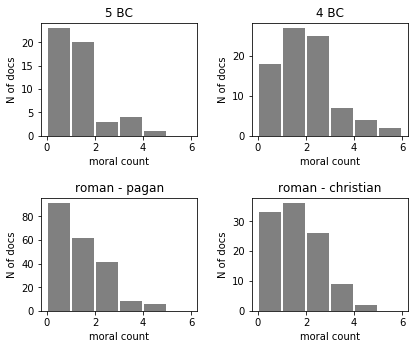

In [0]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(LG_data_results[LG_data_results["century"]==-4.5]["moral_count"], bins=[0,1,2,3,4,5,6], rwidth=0.9, color="gray")
axs[0, 0].set_title('5 BC')
axs[0, 1].hist(LG_data_results[LG_data_results["century"]==-3.5]["moral_count"], bins=[0,1,2,3,4,5,6], rwidth=0.9, color="gray")
axs[0, 1].set_title('4 BC')
axs[1, 0].hist(LG_data_results[(LG_data_results["provenience"]=="pagan") & (LG_data_results["period"]=="roman")]["moral_count"], bins=[0,1,2,3,4,5,6], rwidth=0.9, color="gray")
axs[1, 0].set_title('roman - pagan')
axs[1, 1].hist(LG_data_results[LG_data_results["provenience"]=="christian"]["moral_count"], bins=[0,1,2,3,4,5,6], rwidth=0.9, color="gray")
axs[1, 1].set_title('roman - christian')

for ax in axs.flat:
    ax.set(xlabel='moral count', ylabel='N of docs')

plt.subplots_adjust(top=1, bottom=0, left=0.10, right=0.95, hspace=0.55,
                    wspace=0.35)
fig.savefig(gdrive_root + "figures/hist_moral_counts.png", bbox_inches="tight")

In [0]:
fig.savefig(gdrive_root + "figures/hist_moral_counts.png")

In [0]:
ecdf(LG_data_results[LG_data_results["period"]=="classical"]["moral_count"])[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       5, 6])

In [0]:
sns.scatterplot(x = ecdf(LG_data_results["period"]=="classical"]["moral_count"])[0], y= ecdf(LG_data_results["period"]=="classical"]["moral_count"])[1])

SyntaxError: ignored

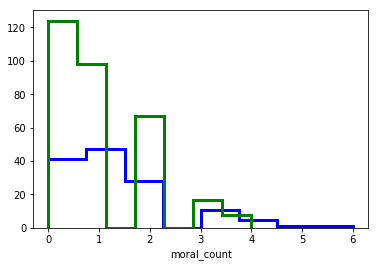

In [0]:
sns.distplot(LG_data_results[LG_data_results["period"]=="classical"]["moral_count"], kde=False, hist_kws={"histtype": "step" , "linewidth": 3, "alpha": 1, "color": "b"})
sns.distplot(LG_data_results[LG_data_results["period"]=="roman"]["moral_count"], kde=False, hist_kws={"histtype": "step" , "linewidth": 3, "alpha": 1, "color": "g"})

In [0]:
 ax = sns.distplot(x, rug=True, rug_kws={"color": "g"}, kde_kws={"color": "k", "lw": 3, "label": "KDE"}, hist_kws={"histtype": "step", "linewidth": 3,    "alpha": 1, "color": "g"})

In [0]:
set_with_dataframe(sh.add_worksheet("results_by_centuries", cols=1, rows=1), LG_data_results.groupby("century")["moral_count"].describe().round(5))

In [0]:
LG_data_results[LG_data_results["provenience"]=="christian"].groupby("century")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
century,,,,,,,,
0.5,29.0,1.000000,0.707107,0.0,1.0,1.0,1.0,3.0
1.5,22.0,1.318182,0.994574,0.0,1.0,1.0,2.0,3.0
2.5,27.0,1.148148,1.321529,0.0,0.0,1.0,2.0,4.0
3.5,28.0,1.214286,1.031258,0.0,0.0,1.0,2.0,3.0


In [0]:
LG_data_results.groupby("period")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
period,,,,,,,,
archaic,6.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
classical,134.0,1.246269,1.197972,0.0,0.0,1.0,2.0,6.0
roman,314.0,1.003185,1.028347,0.0,0.0,1.0,2.0,4.0


In [0]:
import seaborn as sns


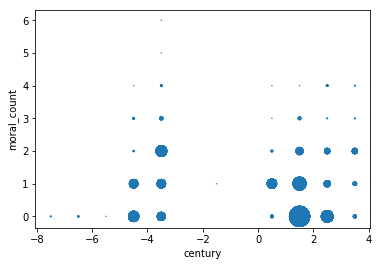

In [0]:
def like_me_here(row):
  like_me_here_count = len(LG_data_results[(LG_data_results["century"]== row["century"]) & (LG_data_results["moral_count"]== row["moral_count"])])
  return like_me_here_count
LG_data_results["like_me_here"] = LG_data_results.apply(lambda row: like_me_here(row), axis=1)

LG_data_results.plot.scatter(x="century", y="moral_count", s=(LG_data_results["like_me_here"]**2)/5)

In [46]:
proxies_df = sddk.read_file("https://sciencedata.dk/shared/2f7a60617c9171d2990a45902c6b1762?download", "df")
proxies_df

,century,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons
0,-7.5,21250,87500,1.30,51.0,archaic,1.0,1.0,1.0
1,-6.5,21750,112500,2.50,49.0,archaic,1.0,1.0,1.0
2,-5.5,22500,137500,4.25,70.0,archaic,1.0,1.0,1.0
3,-4.5,23500,150000,6.35,149.0,classical,2.0,3.0,2.0
4,-3.5,25000,150000,8.25,230.0,classical,2.0,3.0,2.0
5,-2.5,26500,225000,7.95,NaN,None,NaN,NaN,NaN
6,-1.5,28000,350000,5.85,NaN,None,NaN,NaN,NaN
7,-0.5,30000,700000,4.70,NaN,None,NaN,NaN,NaN
8,0.5,31000,1000000,NaN,NaN,roman,3.0,2.0,2.0
9,1.5,30500,1000000,NaN,NaN,roman,3.0,2.0,2.0


In [0]:
LG_data_results = LG_data_results.merge(proxies_df, on="century")
LG_data_results.head(3)

,author,work,ids,length_orig,length_lemmata,provenience,century,notes,lemmata,nouns_and_adj,string,nouns_adj_length,theos_egonetwork,moral_terms,moral_count,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons
0,Eutropius,Breviarium historiae romanae,stoa0121.stoa001.opp-grc1,26143,13086,pagan,3.5,None,"[ῥωμαϊκός, βασίλεια, προοίμιον, οὐδείς, γίγνομ...","[ῥωμαϊκός, βασίλεια, προοίμιον, οὐδείς, μεῖόν,...",Τῆς Ῥωμαϊκῆς βασιλείας ἐν προοιμίοις οὐδὲν ἐγέ...,8941,"[(προσηγορία, [an appellation, name], 0.25), (...",[],0,28750,800000,NaN,NaN,roman,3.0,2.0,2.0
1,Hegemonius,Acta Archelai,stoa0146d.stoa001.opp-grc1,2725,1161,christian,3.5,None,"[μανιχαῖος, ἀπόστολος, ἰησοῦς, χριστός, πᾶς, ἅ...","[μανιχαῖος, ἀπόστολος, ἰησοῦς, χριστός, πᾶς, ἅ...",Μανιχαῖος ἀπόστολος Ἰησοῦ Χριστοῦ καὶ οἱ σὺν ἐ...,727,"[(εἰρήνη, [peace, peace of mind], 1.0), (πατήρ...","[ἀγαθωσύνη, ἀγαθός, καλός]",3,28750,800000,NaN,NaN,roman,3.0,2.0,2.0
2,Ammonius Grammaticus,De adfinium vocabulorum differentia ΠΕΡΙ ΟΜΟΙΩ...,tlg0708.tlg001.1st1K-grc1,21952,8597,pagan,3.5,None,"[ἀβακιον, διαφέρω, ἄβαξ, πρᾶγμα, παρατίθημι, ἀ...","[ἀβακιον, ἄβαξ, πρᾶγμα, παρατίθημι, ἀβέβηλος, ...","A ἄβαξ καὶ ἀβακιον διαφέρει . ἄβαξ μὲν γάρ , ἐ...",5298,"[(μάχη, [strife, contention, quarrel], 0.5), (...",[ἄξιος],1,28750,800000,NaN,NaN,roman,3.0,2.0,2.0


In [0]:
LG_data_results.groupby("period")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
period,,,,,,,,
archaic,6.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
classical,124.0,1.258065,1.242021,0.0,0.0,1.0,2.0,6.0
roman,219.0,1.027397,1.057597,0.0,0.0,1.0,2.0,4.0


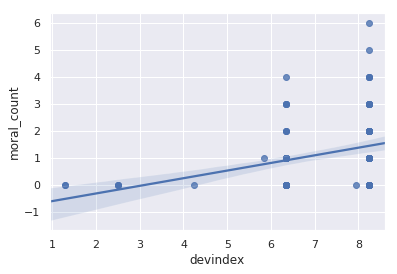

In [0]:
### see https://seaborn.pydata.org/tutorial/regression.html


sns.set(color_codes=True)
sns.regplot(x="devindex", y="moral_count", data=LG_data_results)

In [0]:
LG_data_results["author"] = LG_data_results.apply(lambda row: str(row["author"]), axis=1)

In [0]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [0]:
md = smf.mixedlm("moral_count ~ devindex", LG_data_results[LG_data_results["century"]<0], groups=LG_data_results[LG_data_results["century"]<0]["author"])
mdf = md.fit()
print(mdf.summary())


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: moral_count
No. Observations: 142     Method:             REML       
No. Groups:       27      Scale:              1.0455     
Min. group size:  1       Likelihood:         -214.4877  
Max. group size:  20      Converged:          Yes        
Mean group size:  5.3                                    
----------------------------------------------------------
           Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept  -0.641     0.618  -1.037  0.300  -1.853   0.571
devindex    0.234     0.086   2.718  0.007   0.065   0.403
Group Var   0.213     0.111                               

